# Stratégie probabiliste sur les contrats up/down Polymarket

Ce notebook explore comment estimer en continu la probabilité qu'une bougie Bitcoin se clôture au-dessus ou au-dessous de son prix d'ouverture pour trois horizons (m15, h1, daily en timezone ET), puis comment exploiter les déséquilibres de cotes observés lors de phases de FOMO.

Le pipeline couvre : (1) l'ingestion des données OHLC minute, (2) l'ingénierie de features multi-échelles, (3) l'entraînement de modèles de probabilités, (4) la simulation d'une cote « FOMO » paramétrable et (5) un backtest value simple pour quantifier l'edge potentiel.

**📋 Ordre logique d'exécution des sections :**
0. Setup & Configuration (imports, constantes, fonctions)
1. Chargement et préparation des données (OHLC + indicateurs)
2. Reconstruction multi-échelle (snapshots par timeframe)
3. Modèles intrabougie (entraînement, probabilités, visualisations)
4. Probabilités pré-ouverture (modèles pré-open, seuils, visualisations)
5. Simulation des cotes FOMO (génération de scénarios)
   5.1 Calibration du modèle FOMO (comparaison avec vraies cotes marché)
6. Backtest ONLINE (trading minute-par-minute, métriques)
7. Visualisations et analyse (courbes d'équity, distributions, timing)
8. Backtest ONLINE avec cotes marché réelles
9. Lecture modèle (feature importances)
10. Synthèse et prochaines étapes


## 0. Setup & Configuration

Configuration de l'environnement, imports, constantes et définition de toutes les fonctions utilitaires utilisées dans le notebook.

- But: centraliser toute la configuration et les fonctions de base.
- Entrées: aucune.
- Sorties: fonctions et constantes globales disponibles pour les sections suivantes.
- Lecture: section à exécuter en premier.


In [1]:
from __future__ import annotations

import math
import pathlib
from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates
from IPython.display import display
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score,
)


In [2]:
pd.options.display.max_columns = 120
pd.options.display.max_rows = 200

DATA_PATH = pathlib.Path("../data/btc_1m_OHLC.csv").resolve()
MARKET_ODDS_PATH = pathlib.Path("../data/BTC.csv").resolve()
TARGET_TZ = "America/New_York"
RANDOM_SEED = 17

np.random.seed(RANDOM_SEED)


In [3]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11


In [4]:
def announce(msg: str) -> None:
    print(f"[INFO] {msg}")


### 0.1 Fonctions de chargement et indicateurs


In [5]:
def load_minute_data(path: pathlib.Path) -> pd.DataFrame:
    """Charge les données OHLCV minute et impose un index temporel UTC."""
    df = pd.read_csv(path)
    df = df.sort_values("timestamp")
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True)
    df = df.set_index("timestamp")
    df = df.rename(
        columns={
            "open": "open",
            "high": "high",
            "low": "low",
            "close": "close",
            "volume": "volume",
        }
    )
    df.index.name = "timestamp_utc"
    return df


def compute_rsi(close: pd.Series, period: int = 14) -> pd.Series:
    """Calcule un RSI classique sur une série de clôtures."""
    delta = close.diff()
    gain = delta.clip(lower=0).ewm(alpha=1 / period, adjust=False).mean()
    loss = -delta.clip(upper=0).ewm(alpha=1 / period, adjust=False).mean()
    rs = gain / (loss + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi


def add_global_indicators(df: pd.DataFrame) -> pd.DataFrame:
    enriched = df.copy()
    enriched["return_1m"] = enriched["close"].pct_change().fillna(0.0)
    enriched["ema_12"] = enriched["close"].ewm(span=12, adjust=False).mean()
    enriched["ema_48"] = enriched["close"].ewm(span=48, adjust=False).mean()
    enriched["ema_288"] = enriched["close"].ewm(span=288, adjust=False).mean()

    enriched["range_1m"] = (enriched["high"] - enriched["low"]).abs()
    enriched["atr_15m"] = enriched["range_1m"].rolling(15).mean().bfill()
    enriched["sigma_15m"] = enriched["return_1m"].rolling(15).std().bfill() * math.sqrt(15)

    enriched["rsi_14"] = compute_rsi(enriched["close"])
    enriched["rolling_vol_30"] = enriched["return_1m"].rolling(30).std().fillna(0.0) * math.sqrt(30)
    enriched["volume_per_minute"] = enriched["volume"].rolling(30).mean().bfill()
    enriched["volume_z"] = ((enriched["volume"] - enriched["volume"].rolling(120).mean())
                            / (enriched["volume"].rolling(120).std() + 1e-9)).fillna(0.0)
    enriched["trend_ema_ratio"] = (enriched["ema_12"] - enriched["ema_48"]) / (enriched["ema_48"] + 1e-9)
    enriched["macro_trend_ratio"] = (enriched["ema_48"] - enriched["ema_288"]) / (enriched["ema_288"] + 1e-9)
    enriched["is_trend_up"] = (enriched["trend_ema_ratio"] > 0).astype(int)
    return enriched


### 0.2 Fonctions de reconstruction multi-échelle


In [6]:

def build_timeframe_snapshots(
    df: pd.DataFrame,
    freq: str,
    label: str,
    target_tz: str | None = None,
) -> pd.DataFrame:
    """Agrège les minutes en se basant sur les bornes temporelles alignées sur ET."""
    tz = target_tz
    if tz is None:
        try:
            tz = TARGET_TZ
        except NameError:
            tz = "America/New_York"

    local = df.copy()
    local["timestamp_et"] = local.index.tz_convert(tz)

    if label == "d1":
        bucket_start_et = local["timestamp_et"].apply(_daily_bucket_start_12pm_et)
        bucket_end_et = bucket_start_et + pd.Timedelta(days=1)
    else:
        ts_local = local["timestamp_et"]
        bucket_start_naive = ts_local.dt.tz_localize(None).dt.floor(freq)
        bucket_start_et = bucket_start_naive.dt.tz_localize(
            tz, ambiguous="NaT", nonexistent="shift_forward"
        )
        mask_valid = bucket_start_et.notna()
        if not mask_valid.all():
            local = local.loc[mask_valid].copy()
            ts_local = ts_local.loc[mask_valid]
            bucket_start_et = bucket_start_et.loc[mask_valid]
            local["timestamp_et"] = ts_local
        bucket_end_et = bucket_start_et + pd.to_timedelta(freq)

    bucket_start_utc = bucket_start_et.dt.tz_convert("UTC")
    bucket_end_utc = bucket_end_et.dt.tz_convert("UTC")

    local["bucket_start_et"] = bucket_start_et
    local["bucket_end_et"] = bucket_end_et
    local["bucket_start_utc"] = bucket_start_utc
    local["bucket_end_utc"] = bucket_end_utc
    local["bucket_key"] = bucket_start_utc

    group = local.groupby("bucket_key", group_keys=False)
    local["tf_open"] = group["open"].transform("first")
    local["tf_high_to_now"] = group["high"].cummax()
    local["tf_low_to_now"] = group["low"].cummin()
    local["tf_close_to_now"] = local["close"]
    local["tf_volume_to_now"] = group["volume"].cumsum()
    local["tf_final_close"] = group["close"].transform("last")
    local["tf_final_high"] = group["high"].transform("max")
    local["tf_final_low"] = group["low"].transform("min")

    local["minutes_elapsed"] = group.cumcount() + 1
    local["bucket_size"] = group["close"].transform("size")
    local["minutes_total"] = local["bucket_size"].clip(lower=1)
    local["minutes_remaining"] = (
        local["minutes_total"] - local["minutes_elapsed"]
    ).clip(lower=0)
    local["seconds_remaining"] = local["minutes_remaining"] * 60
    local["time_elapsed_ratio"] = local["minutes_elapsed"] / local["minutes_total"]
    local["time_remaining_ratio"] = (
        local["minutes_remaining"] / local["minutes_total"]
    )

    local["target_up"] = (local["tf_final_close"] >= local["tf_open"]).astype(int)

    local["dist_from_open_pct"] = (
        (local["tf_close_to_now"] - local["tf_open"]) / (local["tf_open"] + 1e-9)
    )
    local["high_gap_pct"] = (
        (local["tf_high_to_now"] - local["tf_close_to_now"]) / (local["tf_open"] + 1e-9)
    )
    local["low_gap_pct"] = (
        (local["tf_close_to_now"] - local["tf_low_to_now"]) / (local["tf_open"] + 1e-9)
    )
    local["running_range_pct"] = (
        (local["tf_high_to_now"] - local["tf_low_to_now"]) / (local["tf_open"] + 1e-9)
    )
    local["minute_body_pct"] = (
        (local["close"] - local["open"]) / (local["tf_open"] + 1e-9)
    )

    local["z_dist_atr15"] = (
        (local["tf_close_to_now"] - local["tf_open"]) / (local["atr_15m"] + 1e-6)
    )
    local["z_range_atr15"] = (
        (local["tf_high_to_now"] - local["tf_low_to_now"]) / (local["atr_15m"] + 1e-6)
    )

    local["minute_of_day"] = (
        local["timestamp_et"].dt.hour * 60 + local["timestamp_et"].dt.minute
    )
    local["minute_of_week"] = (
        local["timestamp_et"].dt.dayofweek * 1440 + local["minute_of_day"]
    )
    local["minute_of_day_sin"] = np.sin(2 * np.pi * local["minute_of_day"] / 1440)
    local["minute_of_day_cos"] = np.cos(2 * np.pi * local["minute_of_day"] / 1440)
    local["day_of_week"] = local["timestamp_et"].dt.dayofweek
    local["day_of_week_sin"] = np.sin(2 * np.pi * local["day_of_week"] / 7)
    local["day_of_week_cos"] = np.cos(2 * np.pi * local["day_of_week"] / 7)

    def _streak_bool(series: pd.Series) -> pd.Series:
        count = 0
        out = []
        for v in series.astype(bool):
            if v:
                count += 1
            else:
                count = 0
            out.append(count)
        return pd.Series(out, index=series.index)

    local["minute_up"] = (local["close"] >= local["open"]).astype(int)
    local["minute_down"] = 1 - local["minute_up"]
    local["tf_up_to_now"] = (local["tf_close_to_now"] >= local["tf_open"]).astype(int)
    local["tf_down_to_now"] = 1 - local["tf_up_to_now"]

    local["streak_up_minute"] = local.groupby("bucket_key")["minute_up"].apply(_streak_bool)
    local["streak_down_minute"] = local.groupby("bucket_key")["minute_down"].apply(_streak_bool)
    local["streak_tf_up"] = local.groupby("bucket_key")["tf_up_to_now"].apply(_streak_bool)
    local["streak_tf_down"] = local.groupby("bucket_key")["tf_down_to_now"].apply(_streak_bool)

    bucket_summary = (
        local.groupby("bucket_key")
        .agg(
            bucket_open=("tf_open", "first"),
            bucket_close=("tf_final_close", "first"),
            bucket_high=("tf_final_high", "first"),
            bucket_low=("tf_final_low", "first"),
            bucket_minutes=("minutes_total", "first"),
            bucket_target=("target_up", "first"),
        )
        .sort_index()
    )
    bucket_summary["bucket_return"] = (
        (bucket_summary["bucket_close"] - bucket_summary["bucket_open"])
        / (bucket_summary["bucket_open"] + 1e-9)
    )
    bucket_summary["bucket_range"] = (
        (bucket_summary["bucket_high"] - bucket_summary["bucket_low"])
        / (bucket_summary["bucket_open"] + 1e-9)
    )
    bucket_summary["prev_bucket_return"] = bucket_summary["bucket_return"].shift(1)
    bucket_summary["prev_bucket_target"] = bucket_summary["bucket_target"].shift(1)
    bucket_summary["prev_bucket_range"] = bucket_summary["bucket_range"].shift(1)

    local = local.join(
        bucket_summary[
            [
                "prev_bucket_return",
                "prev_bucket_target",
                "prev_bucket_range",
            ]
        ],
        on="bucket_key",
    )

    local["prev_bucket_return"].fillna(0.0, inplace=True)
    local["prev_bucket_target"].fillna(0.5, inplace=True)
    local["prev_bucket_range"].fillna(0.0, inplace=True)

    local["timeframe"] = label
    local["contract_id"] = (
        label
        + "_"
        + local["bucket_start_utc"].dt.strftime("%Y-%m-%d %H:%M")
    )
    return local


In [7]:
def prepare_timeframe_dataset(
    df: pd.DataFrame,
    mapping: Dict[str, str],
    target_tz: str | None = None,
) -> pd.DataFrame:
    """Assemble les flux enrichis pour chaque horizon demandé."""
    tz = target_tz
    if tz is None:
        try:
            tz = TARGET_TZ
        except NameError:
            tz = "America/New_York"

    frames = []
    for label, freq in mapping.items():
        frame = build_timeframe_snapshots(df, freq=freq, label=label, target_tz=tz)
        frames.append(frame)
    combined = pd.concat(frames).sort_index()
    combined = combined[combined["minutes_remaining"] > 0]
    combined = combined.dropna(subset=["tf_open", "tf_close_to_now"])
    return combined


In [8]:
def build_preopen_dataset(
    minute_df: pd.DataFrame,
    mapping: Dict[str, str],
    target_tz: str | None = None,
) -> pd.DataFrame:
    """Construit un dataset avant l'ouverture de chaque bougie cible."""
    tz = target_tz or TARGET_TZ

    records = []
    for label, freq in mapping.items():
        full_snapshots = build_timeframe_snapshots(
            minute_df,
            freq=freq,
            label=label,
            target_tz=tz,
        )

        bucket_meta = (
            full_snapshots.groupby("contract_id")
            .agg(
                bucket_start_utc=("bucket_start_utc", "first"),
                bucket_start_et=("bucket_start_et", "first"),
                target_up=("target_up", "first"),
                prev_bucket_return=("prev_bucket_return", "first"),
                prev_bucket_target=("prev_bucket_target", "first"),
                prev_bucket_range=("prev_bucket_range", "first"),
            )
            .reset_index()
            .sort_values("bucket_start_utc")
        )

        for _, row in bucket_meta.iterrows():
            snapshot_time = row["bucket_start_utc"] - pd.Timedelta(minutes=1)
            if snapshot_time not in minute_df.index:
                continue
            base = minute_df.loc[snapshot_time]
            minute_et = snapshot_time.tz_convert(tz)
            minute_of_day = minute_et.hour * 60 + minute_et.minute
            day_of_week = minute_et.dayofweek
            records.append(
                {
                    "timeframe": label,
                    "contract_id": row["contract_id"],
                    "snapshot_utc": snapshot_time,
                    "bucket_start_utc": row["bucket_start_utc"],
                    "target_up": row["target_up"],
                    "prev_bucket_return": row["prev_bucket_return"],
                    "prev_bucket_target": row["prev_bucket_target"],
                    "prev_bucket_range": row["prev_bucket_range"],
                    "ema_12": base["ema_12"],
                    "ema_48": base["ema_48"],
                    "ema_288": base["ema_288"],
                    "trend_ema_ratio": base["trend_ema_ratio"],
                    "macro_trend_ratio": base["macro_trend_ratio"],
                    "rsi_14": base["rsi_14"],
                    "rolling_vol_30": base["rolling_vol_30"],
                    "volume_per_minute": base["volume_per_minute"],
                    "volume_z": base["volume_z"],
                    "minute_of_day": minute_of_day,
                    "minute_of_day_sin": np.sin(2 * np.pi * minute_of_day / 1440),
                    "minute_of_day_cos": np.cos(2 * np.pi * minute_of_day / 1440),
                    "day_of_week": day_of_week,
                    "day_of_week_sin": np.sin(2 * np.pi * day_of_week / 7),
                    "day_of_week_cos": np.cos(2 * np.pi * day_of_week / 7),
                }
            )
    preopen_df = pd.DataFrame.from_records(records)
    preopen_df.sort_values("bucket_start_utc", inplace=True)
    return preopen_df



### 0.3 Fonctions de modélisation


In [9]:
PREOPEN_FEATURES = [
    "prev_bucket_return",
    "prev_bucket_target",
    "prev_bucket_range",
    "ema_12",
    "ema_48",
    "ema_288",
    "trend_ema_ratio",
    "macro_trend_ratio",
    "rsi_14",
    "rolling_vol_30",
    "volume_per_minute",
    "volume_z",
    "minute_of_day",
    "minute_of_day_sin",
    "minute_of_day_cos",
    "day_of_week",
    "day_of_week_sin",
    "day_of_week_cos",
]

In [10]:
FEATURE_COLUMNS = [
    "dist_from_open_pct",
    "high_gap_pct",
    "low_gap_pct",
    "running_range_pct",
    "minute_body_pct",
    "time_elapsed_ratio",
    "time_remaining_ratio",
    "minutes_elapsed",
    "minutes_remaining",
    "minutes_total",
    "seconds_remaining",
    "minute_of_day",
    "minute_of_week",
    "minute_of_day_sin",
    "minute_of_day_cos",
    "day_of_week",
    "day_of_week_sin",
    "day_of_week_cos",
    "prev_bucket_return",
    "prev_bucket_target",
    "prev_bucket_range",
    "return_1m",
    "ema_12",
    "ema_48",
    "ema_288",
    "trend_ema_ratio",
    "macro_trend_ratio",
    "rsi_14",
    "rolling_vol_30",
    "volume_per_minute",
    "volume_z",
    "is_trend_up",
    "streak_up_minute",
    "streak_down_minute",
    "streak_tf_up",
    "streak_tf_down",
]

TARGET_COLUMN = "target_up"


In [11]:
def sanitize_features(df: pd.DataFrame, features: Iterable[str]) -> pd.DataFrame:
    """Remplit les valeurs manquantes des features en utilisant la médiane."""
    cleaned = df.copy()
    for col in features:
        if col not in cleaned:
            continue
        median = cleaned[col].median()
        cleaned[col] = cleaned[col].fillna(median if not np.isnan(median) else 0.0)
    return cleaned


In [12]:
@dataclass
class ModelBundle:
    timeframe: str
    model: HistGradientBoostingClassifier
    calibrator: LogisticRegression
    feature_names: List[str]
    metrics: Dict[str, float]
    feature_importances: np.ndarray | None = None


In [13]:
def train_timeframe_models(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str = TARGET_COLUMN,
) -> Dict[str, ModelBundle]:
    """Entraîne un modèle par horizon et renvoie les bundles calibrés."""
    bundles: Dict[str, ModelBundle] = {}
    for timeframe, frame in df.groupby("timeframe"):
        frame = frame.sort_index()
        frame = sanitize_features(frame, feature_cols)
        frame = frame.dropna(subset=[target_col])

        n = len(frame)
        if n < 1000:
            continue

        train_end = int(n * 0.6)
        calib_end = int(n * 0.8)

        train_slice = frame.iloc[:train_end]
        calib_slice = frame.iloc[train_end:calib_end]
        test_slice = frame.iloc[calib_end:]

        X_train = train_slice[feature_cols]
        y_train = train_slice[target_col]

        X_calib = calib_slice[feature_cols]
        y_calib = calib_slice[target_col]

        X_test = test_slice[feature_cols]
        y_test = test_slice[target_col]

        base_model = HistGradientBoostingClassifier(
            learning_rate=0.05,
            max_iter=400,
            max_depth=6,
            l2_regularization=0.01,
            min_samples_leaf=80,
            random_state=RANDOM_SEED,
            scoring="loss",
            tol=1e-4,
        )
        base_model.fit(X_train, y_train)

        calib_preds = base_model.predict_proba(X_calib)[:, 1]
        calib_preds = calib_preds.reshape(-1, 1)
        calibrator = LogisticRegression(max_iter=200)
        calibrator.fit(calib_preds, y_calib)

        test_raw = base_model.predict_proba(X_test)[:, 1]
        test_calibrated = calibrator.predict_proba(test_raw.reshape(-1, 1))[:, 1]

        metrics = {
            "roc_auc": roc_auc_score(y_test, test_calibrated),
            "brier": brier_score_loss(y_test, test_calibrated),
            "accuracy": accuracy_score(y_test, (test_calibrated >= 0.5).astype(int)),
        }

        if hasattr(base_model, "feature_importances_"):
            feature_importances = base_model.feature_importances_
        else:
            perm = permutation_importance(
                base_model,
                X_test,
                y_test,
                n_repeats=5,
                random_state=RANDOM_SEED,
                n_jobs=-1,
            )
            feature_importances = perm.importances_mean

        bundles[timeframe] = ModelBundle(
            timeframe=timeframe,
            model=base_model,
            calibrator=calibrator,
            feature_names=feature_cols,
            metrics=metrics,
            feature_importances=feature_importances,
        )
    return bundles


In [14]:
def infer_probabilities(
    df: pd.DataFrame,
    bundles: Dict[str, ModelBundle],
) -> pd.DataFrame:
    """Applique les modèles calibrés à chaque horizon et renvoie un tableau avec probabilités."""
    results = []
    for timeframe, frame in df.groupby("timeframe"):
        bundle = bundles.get(timeframe)
        if bundle is None:
            continue
        frame_prepared = sanitize_features(frame, bundle.feature_names)
        raw = bundle.model.predict_proba(frame_prepared[bundle.feature_names])[:, 1]
        prob = bundle.calibrator.predict_proba(raw.reshape(-1, 1))[:, 1]
        enriched = frame_prepared.copy()
        enriched["prob_up_raw"] = raw
        enriched["prob_up"] = prob
        results.append(enriched)
    return pd.concat(results).sort_index()


### 0.4 Fonctions de simulation FOMO et backtest


In [15]:
@dataclass
class FomoScenario:
    name: str
    fomo_index: float  # 0 = correction lente, 1 = correction instantanée
    aggressiveness: float  # amplitude du biais
    stickiness: float  # inertie de la cote vis-à-vis du choc
    noise: float = 0.0
    alpha: float = 4.0  # poids sur la distance normalisée
    beta: float = 2.0   # poids sur le range normalisé
    gamma: float = 1.0  # renforcement de fin de période
    k_atr: float = 1.0  # facteur ATR pour la normalisation


def simulate_fomo_odds(
    df: pd.DataFrame,
    scenarios: Iterable[FomoScenario],
) -> pd.DataFrame:
    """Génère des cotes simulées minute par minute pour chaque scénario de FOMO.
    Utilise une distance normalisée par ATR 15m et un renforcement de fin de période."""
    simulated = df.copy()

    def _simulate_group(group: pd.DataFrame, scenario: FomoScenario) -> np.ndarray:
        odds = []
        prev_odds = None
        eps = 1e-6
        for row in group.itertuples():
            base = getattr(row, "prob_up")
            time_decay = getattr(row, "time_remaining_ratio")
            # distances normalisées
            atr = max(getattr(row, "atr_15m", np.nan) * scenario.k_atr, eps)
            z_dist = (getattr(row, "tf_close_to_now") - getattr(row, "tf_open")) / atr
            z_range = (getattr(row, "tf_high_to_now") - getattr(row, "tf_low_to_now")) / atr

            # intensité de fin de période
            end_boost = (1 - time_decay) ** scenario.gamma
            bias = scenario.aggressiveness * np.tanh(scenario.alpha * z_dist + scenario.beta * z_range) * end_boost

            target = float(np.clip(base + bias, 1e-4, 1 - 1e-4))

            if prev_odds is None:
                proposal = target
            else:
                proposal = (
                    scenario.stickiness * prev_odds
                    + (1 - scenario.stickiness) * target
                )
            blended = (
                scenario.fomo_index * base + (1 - scenario.fomo_index) * proposal
            )
            if scenario.noise > 0:
                blended += np.random.normal(0, scenario.noise)
            blended = float(np.clip(blended, 1e-4, 1 - 1e-4))
            odds.append(blended)
            prev_odds = blended
        return np.array(odds)

    for scenario in scenarios:
        column = f"odds_{scenario.name}"
        simulated[column] = np.nan
        for contract_id, group in simulated.groupby("contract_id"):
            series = pd.Series(_simulate_group(group, scenario), index=group.index)
            simulated.loc[group.index, column] = series
    return simulated


In [16]:
def equity_curve(trades: pd.DataFrame, stake_usd: float = 50.0) -> pd.Series:
    """Calcule la courbe d'équity cumulative."""
    if trades.empty:
        return pd.Series(dtype=float)
    ordered = trades.sort_values("timestamp").copy()
    ordered["pnl_usd"] = ordered["pnl"] * stake_usd
    curve = ordered["pnl_usd"].cumsum()
    curve.index = pd.RangeIndex(len(curve))
    return curve


def max_drawdown(series: pd.Series) -> float:
    """Calcule le drawdown maximum (valeur négative)."""
    if series.empty:
        return 0.0
    cummax = series.cummax()
    dd = series - cummax
    return float(dd.min())


def max_consecutive_losses(trades: pd.DataFrame) -> int:
    """Calcule le nombre maximum de pertes consécutives."""
    if trades.empty:
        return 0
    ordered = trades.sort_values("timestamp")
    count = 0
    best = 0
    for v in (ordered["pnl"] <= 0).astype(int).tolist():
        if v == 1:
            count += 1
            best = max(best, count)
        else:
            count = 0
    return best


def build_trades_online_stream(
    df: pd.DataFrame,
    odds_column: str,
    prob_column: str = "prob_up",
    target_column: str = TARGET_COLUMN,
    min_edge: float = 0.05,
    min_seconds_remaining: int = 0,
    spread_abs: float = 0.05,
    fee_abs: float = 0.0,
    min_z_abs: Optional[float] = None,
    allow_multiple: bool = False,
    cooldown_minutes: int = 0,
) -> pd.DataFrame:
    """Parcourt chaque contrat dans l'ordre temporel et déclenche une entrée au premier dépassement du seuil.
    - Pas de max-edge; décision à chaud par minute
    - Un seul trade par contrat par défaut (allow_multiple=False)
    - Option de filtre par distance normalisée (min_z_abs)
    """
    trades: list[dict] = []

    for (timeframe, contract_id), g in df.sort_index().groupby(["timeframe", "contract_id"], sort=False):
        in_cooldown_until = None
        entered = False
        for row in g.itertuples():
            sec_rem = float(getattr(row, "seconds_remaining"))
            if sec_rem < min_seconds_remaining:
                continue
            if min_z_abs is not None and hasattr(row, "z_dist_atr15"):
                if abs(getattr(row, "z_dist_atr15")) < min_z_abs:
                    continue

            ts = row.Index
            if in_cooldown_until is not None and ts < in_cooldown_until:
                continue

            p = float(getattr(row, prob_column))
            mid = float(getattr(row, odds_column))
            edge = p - mid
            if abs(edge) < min_edge:
                continue

            half_spread = spread_abs / 2.0
            if edge > 0:  # acheter YES
                direction = "up"
                paid = np.clip(mid + half_spread, 1e-4, 0.999)
                outcome = int(getattr(row, target_column))
                pnl = outcome - paid - fee_abs
                ev = p - (mid + half_spread) - fee_abs
                model_prob_used = p
            else:  # acheter NO
                direction = "down"
                paid = np.clip((1 - mid) + half_spread, 1e-4, 0.999)
                outcome = 1 - int(getattr(row, target_column))
                pnl = outcome - paid - fee_abs
                ev = (1 - p) - ((1 - mid) + half_spread) - fee_abs
                model_prob_used = 1 - p

            trades.append(
                {
                    "timeframe": timeframe,
                    "contract_id": contract_id,
                    "timestamp": ts,
                    "seconds_remaining": sec_rem,
                    "edge": float(edge),
                    "direction": direction,
                    "price": paid,
                    "model_prob": model_prob_used,
                    "expected_value": ev,
                    "outcome": outcome,
                    "pnl": pnl,
                }
            )

            if not allow_multiple:
                break
            if cooldown_minutes > 0:
                in_cooldown_until = ts + pd.Timedelta(minutes=cooldown_minutes)

    return pd.DataFrame(trades)


def summarize_online_by_timeframe(
    df: pd.DataFrame,
    odds_column: str,
    tolerances: list[float],
    min_seconds_remaining_by_tf: Optional[Dict[str, int]] = None,
    spread_abs: float = 0.05,
    fee_abs: float = 0.0,
    min_z_abs: Optional[float] = None,
    stake_usd: float = 50.0,
) -> pd.DataFrame:
    if min_seconds_remaining_by_tf is None:
        min_seconds_remaining_by_tf = {"m15": 0, "h1": 0, "d1": 0}

    rows: list[dict] = []
    for tf in ["m15", "h1", "d1"]:
        tf_frame = df[df["timeframe"] == tf]
        for tol in tolerances:
            tr = build_trades_online_stream(
                tf_frame,
                odds_column=odds_column,
                min_edge=tol,
                min_seconds_remaining=min_seconds_remaining_by_tf.get(tf, 0),
                spread_abs=spread_abs,
                fee_abs=fee_abs,
                min_z_abs=min_z_abs,
                allow_multiple=False,
            )
            curve = equity_curve(tr, stake_usd=stake_usd)
            mdd = max_drawdown(curve)
            mcl = max_consecutive_losses(tr)
            med_sec = float(tr["seconds_remaining"].median()) if len(tr) else np.nan
            mean_sec = float(tr["seconds_remaining"].mean()) if len(tr) else np.nan
            rows.append(
                {
                    "timeframe": tf,
                    "tolerance": tol,
                    "num_trades": len(tr),
                    "hit_rate": float((tr["pnl"] > 0).mean()) if len(tr) else 0.0,
                    "ev_trade_usd": float(tr["pnl"].mean() * stake_usd) if len(tr) else 0.0,
                    "pnl_total_usd": float((tr["pnl"] * stake_usd).sum()) if len(tr) else 0.0,
                    "max_drawdown_usd": float(mdd),
                    "max_consec_losses": int(mcl),
                    "num_up": int((tr["direction"]=='up').sum()) if len(tr) else 0,
                    "num_down": int((tr["direction"]=='down').sum()) if len(tr) else 0,
                    "up_ratio": float((tr["direction"]=='up').mean()) if len(tr) else 0.0,
                    "median_entry_min": None if np.isnan(med_sec) else round(med_sec / 60.0, 2),
                    "mean_entry_min": None if np.isnan(mean_sec) else round(mean_sec / 60.0, 2),
                }
            )
    return pd.DataFrame(rows).sort_values(["timeframe", "tolerance"])

    


In [17]:
def evaluate_confidence_bands(
    df: pd.DataFrame,
    thresholds: Iterable[float],
    minute_filter: int | None = None,
) -> pd.DataFrame:
    """Mesure la précision obtenue au-delà de différents seuils intrabougie."""
    records = []
    for timeframe, frame in df.groupby("timeframe"):
        subset = frame
        if minute_filter is not None:
            subset = subset[subset["minutes_elapsed"] <= minute_filter]
        for thresh in thresholds:
            selected = subset[subset["prob_up"] >= thresh]
            if selected.empty:
                continue
            hit_rate = selected[TARGET_COLUMN].mean()
            avg_prob = selected["prob_up"].mean()
            avg_edge = (selected["prob_up"] - 0.5).mean()
            records.append(
                {
                    "timeframe": timeframe,
                    "threshold": thresh,
                    "count": len(selected),
                    "hit_rate": hit_rate,
                    "avg_prob": avg_prob,
                    "avg_edge_vs_50pct": avg_edge,
                }
            )
    return pd.DataFrame(records).sort_values(["timeframe", "threshold"])

In [18]:

FOMO_FEATURE_COLUMNS = [
    "prob_up",
    "prob_up_raw",
    "dist_from_open_pct",
    "high_gap_pct",
    "low_gap_pct",
    "running_range_pct",
    "minute_body_pct",
    "time_elapsed_ratio",
    "time_remaining_ratio",
    "minutes_elapsed",
    "minutes_remaining",
    "minutes_total",
    "seconds_remaining",
    "z_dist_atr15",
    "z_range_atr15",
    "return_1m",
    "trend_ema_ratio",
    "macro_trend_ratio",
    "volume_z",
    "streak_up_minute",
    "streak_down_minute",
    "streak_tf_up",
    "streak_tf_down",
    "prev_bucket_return",
    "prev_bucket_range",
]

In [19]:
@dataclass
class FomoModelBundle:
    timeframe: str
    target: str
    model: HistGradientBoostingRegressor
    feature_names: List[str]
    metrics: Dict[str, float]


def train_fomo_models(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str,
    target_name: str,
    min_rows: int = 500,
) -> Dict[str, FomoModelBundle]:
    """Apprend un régresseur FOMO par timeframe pour approcher les cotes marché."""
    bundles: Dict[str, FomoModelBundle] = {}
    for timeframe, frame in df.groupby("timeframe"):
        frame = frame.sort_index()
        frame = frame.dropna(subset=[target_col])
        if len(frame) < min_rows:
            continue

        existing_features = [c for c in feature_cols if c in frame.columns]
        if not existing_features:
            continue

        frame_clean = sanitize_features(frame, existing_features)
        X = frame_clean[existing_features]
        y = frame[target_col]

        n = len(frame)
        train_end = int(n * 0.7)
        val_end = int(n * 0.85)

        X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
        X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
        X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

        if len(X_test) < 100:
            continue

        model = HistGradientBoostingRegressor(
            learning_rate=0.05,
            max_depth=5,
            max_iter=400,
            l2_regularization=0.01,
            min_samples_leaf=60,
            random_state=RANDOM_SEED,
        )
        model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

        test_pred = model.predict(X_test)
        rmse = float(np.sqrt(mean_squared_error(y_test, test_pred)))
        mae = float(mean_absolute_error(y_test, test_pred))
        r2 = float(r2_score(y_test, test_pred))
        similarity_3pct = float((np.abs(test_pred - y_test) <= 0.03).mean())
        similarity_5pct = float((np.abs(test_pred - y_test) <= 0.05).mean())

        bundles[timeframe] = FomoModelBundle(
            timeframe=timeframe,
            target=target_name,
            model=model,
            feature_names=list(existing_features),
            metrics={
                "rmse": rmse,
                "mae": mae,
                "r2": r2,
                "similarity_3pct": similarity_3pct,
                "similarity_5pct": similarity_5pct,
                "n_test": len(X_test),
            },
        )
    return bundles

In [20]:

def apply_fomo_models(
    df: pd.DataFrame,
    bundles: Dict[str, FomoModelBundle],
    feature_cols: List[str],
) -> pd.Series:
    """Génère les prédictions FOMO pour chaque timeframe présent dans df."""
    preds = pd.Series(np.nan, index=df.index, dtype=float)
    for timeframe, bundle in bundles.items():
        mask = df["timeframe"] == timeframe
        if not mask.any():
            continue
        existing_features = [c for c in bundle.feature_names if c in df.columns]
        if not existing_features:
            continue
        frame = sanitize_features(df.loc[mask], existing_features)
        X = frame[existing_features]
        preds.loc[mask] = bundle.model.predict(X)
    return preds


In [21]:

def summarize_fomo_performance(
    df: pd.DataFrame,
    prediction_col: str,
    target_col: str,
    similarity_threshold: float = 0.03,
) -> pd.DataFrame:
    """Calcule les métriques d'alignement modèle ↔ marché par timeframe."""
    records: list[dict] = []
    subset = df.dropna(subset=[prediction_col, target_col])
    for timeframe, frame in subset.groupby("timeframe"):
        diff = frame[prediction_col] - frame[target_col]
        rmse = float(np.sqrt((diff**2).mean()))
        mae = float(diff.abs().mean())
        bias = float(diff.mean())
        similarity = float((diff.abs() <= similarity_threshold).mean())
        records.append(
            {
                "timeframe": timeframe,
                "n": len(frame),
                "rmse": rmse,
                "mae": mae,
                "bias": bias,
                "similarity_threshold": similarity_threshold,
                "similarity_ratio": similarity,
            }
        )
    return pd.DataFrame(records).sort_values("timeframe")

In [22]:
def equity_curve_with_capital(
    trades: pd.DataFrame,
    initial_capital: float = 1000.0,
    strategy_type: str = "risk_pct",  # "risk_pct" ou "shares_pct"
    pct_value: float = 0.02,
) -> Tuple[pd.Series, pd.Series]:
    """Calcule la courbe d'équity et le capital après chaque trade."""
    if trades.empty:
        return pd.Series(dtype=float), pd.Series(dtype=float)

    ordered = trades.sort_values("timestamp").copy()
    capital = initial_capital
    equity_values: list[float] = []
    capital_values: list[float] = []

    for _, trade in ordered.iterrows():
        price = trade["price"]
        if strategy_type == "risk_pct":
            stake_usd = capital * pct_value
            shares = stake_usd / max(price, 1e-6)
            pnl_usd = trade["pnl"] * shares
        elif strategy_type == "shares_pct":
            shares = initial_capital * pct_value
            pnl_usd = trade["pnl"] * shares
        else:
            raise ValueError("strategy_type doit être 'risk_pct' ou 'shares_pct'")

        capital += pnl_usd
        equity_values.append(capital)
        capital_values.append(capital)

    equity_curve = pd.Series(equity_values, index=pd.RangeIndex(len(equity_values)))
    capital_series = pd.Series(capital_values, index=pd.RangeIndex(len(capital_values)))
    return equity_curve, capital_series


def summarize_online_by_timeframe_with_capital(
    df: pd.DataFrame,
    odds_column: str,
    tolerances: list[float],
    initial_capital: float = 1000.0,
    strategy_type: str = "risk_pct",
    pct_value: float = 0.02,
    min_seconds_remaining_by_tf: Optional[Dict[str, int]] = None,
    spread_abs: float = 0.05,
    fee_abs: float = 0.0,
    min_z_abs: Optional[float] = None,
) -> Tuple[pd.DataFrame, Dict[str, pd.Series]]:
    """Résumé ONLINE intégrant la gestion de capital dynamique."""
    if min_seconds_remaining_by_tf is None:
        min_seconds_remaining_by_tf = {"m15": 0, "h1": 0, "d1": 0}

    rows: list[dict] = []
    equity_curves: Dict[str, pd.Series] = {}
    total_contracts = df.groupby("timeframe")["contract_id"].nunique()

    for tf in ["m15", "h1", "d1"]:
        tf_frame = df[df["timeframe"] == tf]
        for tol in tolerances:
            tr = build_trades_online_stream(
                tf_frame,
                odds_column=odds_column,
                prob_column="prob_up",
                min_edge=tol,
                min_seconds_remaining=min_seconds_remaining_by_tf.get(tf, 0),
                spread_abs=spread_abs,
                fee_abs=fee_abs,
                min_z_abs=min_z_abs,
                allow_multiple=False,
            )

            curve, capital_series = equity_curve_with_capital(
                tr,
                initial_capital=initial_capital,
                strategy_type=strategy_type,
                pct_value=pct_value,
            )

            mdd = max_drawdown(curve)
            mcl = max_consecutive_losses(tr)
            med_sec = float(tr["seconds_remaining"].median()) if len(tr) else np.nan
            mean_sec = float(tr["seconds_remaining"].mean()) if len(tr) else np.nan
            num_contracts = total_contracts.get(tf, 0)
            prob_trade = len(tr) / num_contracts if num_contracts else 0.0

            if len(tr) > 0 and not capital_series.empty:
                final_capital = float(capital_series.iloc[-1])
                pnl_total = final_capital - initial_capital
                if strategy_type == "risk_pct":
                    avg_stake = (capital_series.shift(fill_value=initial_capital) * pct_value).mean()
                else:
                    shares_count = initial_capital * pct_value
                    avg_price = tr["price"].mean()
                    avg_stake = shares_count * avg_price
                ev_trade = pnl_total / len(tr)
            else:
                final_capital = initial_capital
                pnl_total = 0.0
                avg_stake = 0.0
                ev_trade = 0.0

            rows.append(
                {
                    "timeframe": tf,
                    "tolerance": tol,
                    "num_trades": len(tr),
                    "hit_rate": float((tr["pnl"] > 0).mean()) if len(tr) else 0.0,
                    "ev_trade_usd": ev_trade,
                    "pnl_total_usd": pnl_total,
                    "final_capital_usd": final_capital,
                    "avg_stake_usd": avg_stake,
                    "max_drawdown_usd": float(mdd),
                    "max_consec_losses": int(mcl),
                    "num_up": int((tr["direction"] == "up").sum()) if len(tr) else 0,
                    "num_down": int((tr["direction"] == "down").sum()) if len(tr) else 0,
                    "up_ratio": float((tr["direction"] == "up").mean()) if len(tr) else 0.0,
                    "prob_trade": prob_trade,
                    "median_entry_min": None if np.isnan(med_sec) else round(med_sec / 60.0, 2),
                    "mean_entry_min": None if np.isnan(mean_sec) else round(mean_sec / 60.0, 2),
                }
            )

            equity_curves[f"{tf}_{tol}"] = curve

    summary = pd.DataFrame(rows).sort_values(["timeframe", "tolerance"])
    return summary, equity_curves



### 0.5 Fonctions de calibration marché (optionnelles)


In [23]:
def load_market_csv(csv_path: str) -> pd.DataFrame:
    dfm = pd.read_csv(csv_path)
    dfm['timestamp'] = pd.to_datetime(dfm['timestamp'], utc=True, errors='coerce')
    dfm = dfm.dropna(subset=['timestamp']).sort_values('timestamp')
    dfm = dfm.set_index('timestamp').rename_axis('timestamp_utc')
    dfm['m15_prob_up'] = dfm['m15_buy']
    dfm['h1_prob_up'] = dfm['h1_buy']
    dfm['d1_prob_up'] = dfm['daily_buy']
    dfm['m15_mid'] = (dfm['m15_buy'] + dfm['m15_sell']) / 2
    dfm['h1_mid'] = (dfm['h1_buy'] + dfm['h1_sell']) / 2
    dfm['d1_mid'] = (dfm['daily_buy'] + dfm['daily_sell']) / 2
    return dfm

In [24]:
def _daily_bucket_start_12pm_et(ts_et: pd.Timestamp) -> pd.Timestamp:
    base = ts_et.floor('D') + pd.Timedelta(hours=12)
    return base if ts_et >= base else base - pd.Timedelta(days=1)

def merge_market_with_sim(simulated_df: pd.DataFrame, market_long: pd.DataFrame) -> pd.DataFrame:
    left = simulated_df.copy().reset_index()
    index_col = simulated_df.index.name or 'index'
    if index_col not in left.columns:
        index_col = left.columns[0]
    left = left.rename(columns={index_col: 'timestamp_model_utc'})
    left['minute_utc'] = pd.to_datetime(left['timestamp_model_utc'], utc=True).dt.floor('1min')

    right = market_long.reset_index()
    right_index = market_long.index.name or 'index'
    if right_index not in right.columns:
        right_index = right.columns[0]
    right = right.rename(columns={right_index: 'timestamp_market_utc'})
    right['minute_utc'] = pd.to_datetime(right['timestamp_market_utc'], utc=True).dt.floor('1min')

    merged = pd.merge(
        left,
        right,
        on=['timeframe', 'contract_id', 'minute_utc'],
        how='left',
        suffixes=('', '_market'),
    )

    merged = merged.sort_values(['timeframe', 'contract_id', 'timestamp_model_utc'])
    merged = merged.drop(columns=['minute_utc'])
    merged = merged.set_index('timestamp_model_utc')
    merged.index.name = 'timestamp_utc'
    return merged

In [25]:
def scenario_scores_vs_market(df: pd.DataFrame, scenarios: list[str]) -> pd.DataFrame:
    records = []
    sub = df.dropna(subset=['odds_market_mid'])
    if len(sub) == 0:
        return pd.DataFrame(columns=['timeframe', 'scenario', 'rmse', 'mae', 'n'])
    for tf, g in sub.groupby('timeframe'):
        for sc in scenarios:
            col = f'odds_{sc}'
            if col not in g.columns:
                continue
            gg = g.dropna(subset=[col])
            if len(gg) == 0:
                continue
            err = gg[col] - gg['odds_market_mid']
            rmse = float(np.sqrt((err ** 2).mean()))
            mae = float(err.abs().mean())
            records.append({'timeframe': tf, 'scenario': sc, 'rmse': rmse, 'mae': mae, 'n': len(gg)})
    if len(records) == 0:
        return pd.DataFrame(columns=['timeframe', 'scenario', 'rmse', 'mae', 'n'])
    return pd.DataFrame(records).sort_values(['timeframe', 'rmse'])

In [26]:
def rebuild_ohlc_1m_from_seconds(dfm: pd.DataFrame) -> pd.DataFrame:
    """Reconstruit les OHLC 1 minute à partir des données spot_price à la seconde."""
    dfm = dfm.copy()
    dfm['minute_bucket'] = dfm.index.floor('1min')

    ohlc_1m = dfm.groupby('minute_bucket').agg({
        'spot_price': ['first', 'max', 'min', 'last', 'count']
    })
    ohlc_1m.columns = ['open', 'high', 'low', 'close', 'count']
    ohlc_1m = ohlc_1m.reset_index()
    ohlc_1m = ohlc_1m.set_index('minute_bucket').rename_axis('timestamp_utc')

    # Volume = nombre de ticks par minute (approximation)
    ohlc_1m['volume'] = ohlc_1m['count']
    ohlc_1m = ohlc_1m.drop('count', axis=1)

    return ohlc_1m

In [27]:
def build_market_long_with_stats(dfm: pd.DataFrame) -> pd.DataFrame:
    dfm = dfm.copy().sort_index()
    dfm['timestamp_et'] = dfm.index.tz_convert(TARGET_TZ)
    dfm['minute_utc'] = dfm.index.floor('1min')

    prob_cols = {'m15': 'm15_prob_up', 'h1': 'h1_prob_up', 'd1': 'd1_prob_up'}

    minute_mean_df = (
        dfm.groupby('minute_utc')[list(prob_cols.values())]
        .mean()
        .rename(columns={
            prob_cols['m15']: 'm15_prob_minute_mean',
            prob_cols['h1']: 'h1_prob_minute_mean',
            prob_cols['d1']: 'd1_prob_minute_mean',
        })
    )
    minute_last_df = (
        dfm.groupby('minute_utc')[list(prob_cols.values())]
        .last()
        .rename(columns={
            prob_cols['m15']: 'm15_prob_minute_last',
            prob_cols['h1']: 'h1_prob_minute_last',
            prob_cols['d1']: 'd1_prob_minute_last',
        })
    )
    minute_frame = minute_mean_df.join(minute_last_df)
    minute_frame.index = minute_frame.index.tz_convert('UTC')
    minute_frame['timestamp_et'] = minute_frame.index.tz_convert(TARGET_TZ)

    all_rows: list[dict] = []

    def process_timeframe(label: str, mean_col: str, last_col: str, freq: str) -> None:
        price_col = prob_cols[label]

        if label == 'd1':
            bucket_start_et = minute_frame['timestamp_et'].apply(_daily_bucket_start_12pm_et)
            bucket_end_et = bucket_start_et + pd.Timedelta(days=1)
            bucket_key = dfm['timestamp_et'].apply(_daily_bucket_start_12pm_et)
        else:
            bucket_start_et = minute_frame['timestamp_et'].dt.floor(freq)
            bucket_end_et = bucket_start_et + (pd.Timedelta(minutes=15) if label == 'm15' else pd.Timedelta(hours=1))
            bucket_key = dfm['timestamp_et'].dt.floor(freq)

        stats = (
            dfm.groupby(bucket_key)[price_col]
            .agg(['min', 'max', 'mean', 'last'])
            .rename(columns={
                'min': 'odds_market_min',
                'max': 'odds_market_max',
                'mean': 'odds_market_mean',
                'last': 'odds_market_close',
            })
        )
        stats.index.name = 'bucket_start_et'

        tf_df = pd.DataFrame({
            'timestamp_utc': minute_frame.index,
            'timestamp_et': minute_frame['timestamp_et'],
            'bucket_start_et': bucket_start_et,
            'bucket_end_et': bucket_end_et,
            'odds_market_mid': minute_frame[last_col],
            'odds_market_minute_mean': minute_frame[mean_col],
        })
        tf_df = tf_df.join(stats, on='bucket_start_et')
        tf_df['bucket_start_utc'] = tf_df['bucket_start_et'].dt.tz_convert('UTC')
        tf_df['contract_id'] = label + '_' + tf_df['bucket_start_utc'].dt.strftime('%Y-%m-%d %H:%M')
        tf_df['seconds_remaining'] = (tf_df['bucket_end_et'] - tf_df['timestamp_et']).dt.total_seconds()
        tf_df['timeframe'] = label
        all_rows.extend(tf_df.to_dict('records'))

    process_timeframe('m15', 'm15_prob_minute_mean', 'm15_prob_minute_last', '15min')
    process_timeframe('h1', 'h1_prob_minute_mean', 'h1_prob_minute_last', '1h')
    process_timeframe('d1', 'd1_prob_minute_mean', 'd1_prob_minute_last', '1D')

    market_long = pd.DataFrame(all_rows).dropna(subset=['odds_market_mid'])
    return market_long.sort_values(['timeframe', 'timestamp_utc']).set_index('timestamp_utc')

In [28]:
def train_preopen_models(
    df: pd.DataFrame,
    feature_cols: List[str],
    target_col: str = TARGET_COLUMN,
) -> Dict[str, ModelBundle]:
    """Entraîne un modèle uniquement à partir des informations pré-ouverture."""
    bundles: Dict[str, ModelBundle] = {}
    for timeframe, frame in df.groupby("timeframe"):
        frame = frame.dropna(subset=feature_cols + [target_col])
        if len(frame) < 500:
            continue

        n = len(frame)
        train_end = int(n * 0.7)
        calib_end = int(n * 0.85)

        train_slice = frame.iloc[:train_end]
        calib_slice = frame.iloc[train_end:calib_end]
        test_slice = frame.iloc[calib_end:]

        X_train = train_slice[feature_cols]
        y_train = train_slice[target_col]

        X_calib = calib_slice[feature_cols]
        y_calib = calib_slice[target_col]

        X_test = test_slice[feature_cols]
        y_test = test_slice[target_col]

        base_model = HistGradientBoostingClassifier(
            learning_rate=0.05,
            max_iter=350,
            max_depth=5,
            l2_regularization=0.015,
            min_samples_leaf=60,
            random_state=RANDOM_SEED,
        )
        base_model.fit(X_train, y_train)

        calib_preds = base_model.predict_proba(X_calib)[:, 1]
        calibrator = LogisticRegression(max_iter=200)
        calibrator.fit(calib_preds.reshape(-1, 1), y_calib)

        test_raw = base_model.predict_proba(X_test)[:, 1]
        test_calibrated = calibrator.predict_proba(test_raw.reshape(-1, 1))[:, 1]

        metrics = {
            "roc_auc": roc_auc_score(y_test, test_calibrated),
            "brier": brier_score_loss(y_test, test_calibrated),
            "accuracy": accuracy_score(y_test, (test_calibrated >= 0.5).astype(int)),
        }

        if hasattr(base_model, "feature_importances_"):
            feature_importances = base_model.feature_importances_
        else:
            perm = permutation_importance(
                base_model,
                X_test,
                y_test,
                n_repeats=5,
                random_state=RANDOM_SEED,
                n_jobs=-1,
            )
            feature_importances = perm.importances_mean

        bundles[timeframe] = ModelBundle(
            timeframe=timeframe,
            model=base_model,
            calibrator=calibrator,
            feature_names=feature_cols,
            metrics=metrics,
            feature_importances=feature_importances,
        )
    return bundles


In [29]:
def evaluate_preopen_thresholds(
    df: pd.DataFrame,
    thresholds: Iterable[float],
) -> pd.DataFrame:
    """Calcule la précision avant ouverture selon différents seuils."""
    records = []
    for timeframe, frame in df.groupby("timeframe"):
        for thresh in thresholds:
            selected = frame[frame["prob_up"] >= thresh]
            if selected.empty:
                continue
            hit_rate = selected[TARGET_COLUMN].mean()
            records.append(
                {
                    "timeframe": timeframe,
                    "threshold": thresh,
                    "count": len(selected),
                    "hit_rate": hit_rate,
                    "avg_prob": selected["prob_up"].mean(),
                }
            )
    return pd.DataFrame(records).sort_values(["timeframe", "threshold"])


In [30]:
def top_feature_importances(bundle: ModelBundle, top_n: int = 10) -> pd.DataFrame:
    """Retourne les principales features importées d'un modèle."""
    if bundle.feature_importances is None:
        raise ValueError("Importance des features indisponible pour ce modèle")
    data = pd.DataFrame(
        {
            "feature": bundle.feature_names,
            "importance": bundle.feature_importances,
        }
    )
    data = data.sort_values("importance", ascending=False).head(top_n)
    return data


## 1. Chargement et préparation des données

On charge l'historique BTC m1 (UTC), puis on ajoute les indicateurs globaux nécessaires aux modèles : rendements, EMA multi-échelles, RSI, volatilité et signaux de volume.

- But: obtenir un DataFrame minute enrichi avec indicateurs techniques.
- Entrées: CSV OHLCV minute.
- Sorties: `minute_df` avec colonnes enrichies (EMA, RSI, ATR, volume, etc.).
- Lecture: vérifier que les indicateurs sont calculés correctement.


In [31]:
minute_df = load_minute_data(DATA_PATH)
minute_df = add_global_indicators(minute_df)
print(f"[INFO] Données chargées: {len(minute_df)} lignes de {minute_df.index[0]} à {minute_df.index[-1]}")
minute_df.head()


[INFO] Données chargées: 1501962 lignes de 2023-01-01 00:00:00+00:00 à 2025-11-09 00:41:00+00:00


,open,high,low,close,volume,return_1m,ema_12,ema_48,ema_288,range_1m,atr_15m,sigma_15m,rsi_14,rolling_vol_30,volume_per_minute,volume_z,trend_ema_ratio,macro_trend_ratio,is_trend_up
timestamp_utc,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,16567.0,16568.0,16567.0,16568.0,0.048291,0.000000,16568.000000,16568.000000,16568.000000,1.0,0.8,0.000341,NaN,0.0,0.206287,0.0,0.000000,0.000000,0
2023-01-01 00:01:00+00:00,16568.0,16569.0,16568.0,16569.0,0.008330,0.000060,16568.153846,16568.040816,16568.006920,1.0,0.8,0.000341,100.000000,0.0,0.206287,0.0,0.000007,0.000002,1
2023-01-01 00:02:00+00:00,16569.0,16569.0,16569.0,16569.0,0.017350,0.000000,16568.284024,16568.079967,16568.013793,0.0,0.8,0.000341,100.000000,0.0,0.206287,0.0,0.000012,0.000004,1
2023-01-01 00:03:00+00:00,16568.0,16568.0,16568.0,16568.0,0.012840,-0.000060,16568.240328,16568.076703,16568.013697,0.0,0.8,0.000341,92.349727,0.0,0.206287,0.0,0.000010,0.000004,1
2023-01-01 00:04:00+00:00,16568.0,16568.0,16565.0,16565.0,0.886298,-0.000181,16567.741816,16567.951123,16567.992841,3.0,0.8,0.000341,74.047860,0.0,0.206287,0.0,-0.000013,-0.000003,0


## 2. Reconstruction multi-échelle

On regroupe chaque horizon (m15, h1, daily) en suivant la timezone ET, en calculant pour chaque minute : ouverture de la bougie cible, range parcouru, temps restant et mémoire de la bougie précédente.

- But: créer des snapshots minute-par-minute pour chaque timeframe avec features intrabougie.
- Entrées: `minute_df` enrichi.
- Sorties: `snapshots_df` avec colonnes par timeframe (contract_id, minutes_remaining, dist_from_open_pct, etc.).
- Lecture: vérifier que chaque timeframe a bien ses buckets et features.


In [32]:
TIMEFRAME_MAP = {"m15": "15min", "h1": "1h", "d1": "1d"}

snapshots_df = prepare_timeframe_dataset(minute_df, TIMEFRAME_MAP)
print(f"[INFO] Snapshots créés: {len(snapshots_df)} lignes")
print(f"[INFO] Répartition par timeframe:")
print(snapshots_df.groupby("timeframe").size())
snapshots_df.sample(5, random_state=RANDOM_SEED)


C:\Users\Artex\AppData\Local\Temp\ipykernel_68448\1337738209.py:159: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  local["prev_bucket_return"].fillna(0.0, inplace=True)
C:\Users\Artex\AppData\Local\Temp\ipykernel_68448\1337738209.py:160: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

[INFO] Snapshots créés: 4378982 lignes
[INFO] Répartition par timeframe:
timeframe
d1     1500912
h1     1476575
m15    1401495
dtype: int64


,open,high,low,close,volume,return_1m,ema_12,ema_48,ema_288,range_1m,atr_15m,sigma_15m,rsi_14,rolling_vol_30,volume_per_minute,volume_z,trend_ema_ratio,macro_trend_ratio,is_trend_up,timestamp_et,bucket_start_et,bucket_end_et,bucket_start_utc,bucket_end_utc,bucket_key,tf_open,tf_high_to_now,tf_low_to_now,tf_close_to_now,tf_volume_to_now,tf_final_close,tf_final_high,tf_final_low,minutes_elapsed,bucket_size,minutes_total,minutes_remaining,seconds_remaining,time_elapsed_ratio,time_remaining_ratio,target_up,dist_from_open_pct,high_gap_pct,low_gap_pct,running_range_pct,minute_body_pct,z_dist_atr15,z_range_atr15,minute_of_day,minute_of_week,minute_of_day_sin,minute_of_day_cos,day_of_week,day_of_week_sin,day_of_week_cos,minute_up,minute_down,tf_up_to_now,tf_down_to_now,streak_up_minute,streak_down_minute,streak_tf_up,streak_tf_down,prev_bucket_return,prev_bucket_target,prev_bucket_range,timeframe,contract_id
timestamp_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-03 10:08:00+00:00,62034.0,62038.0,62034.0,62038.0,0.041900,0.000048,62041.975442,62049.084820,61960.996239,4.0,8.8,0.000849,46.326560,0.001409,0.146984,-0.170426,-0.000115,0.001422,0,2024-03-03 05:08:00-05:00,2024-03-02 12:00:00-05:00,2024-03-03 12:00:00-05:00,2024-03-02 17:00:00+00:00,2024-03-03 17:00:00+00:00,2024-03-02 17:00:00+00:00,61911.0,62248.0,61645.0,62038.0,523.659808,61861.0,62248.0,61402.0,1029,1440,1440,411,24660,0.714583,0.285417,0,0.002051,0.003392,0.006348,0.009740,0.000065,14.431817,68.522719,308,8948,0.974370,0.224951,6,-0.781831,0.623490,1,0,1,0,NaN,NaN,NaN,NaN,-0.000097,0.0,0.034802,d1,d1_2024-03-02 17:00
2024-07-25 10:27:00+00:00,64122.0,64124.0,64088.0,64098.0,0.506139,-0.000561,64151.860561,64185.576044,64333.196368,36.0,26.0,0.001629,37.445642,0.002435,0.545864,-0.231600,-0.000525,-0.002295,0,2024-07-25 06:27:00-04:00,2024-07-24 12:00:00-04:00,2024-07-25 12:00:00-04:00,2024-07-24 16:00:00+00:00,2024-07-25 16:00:00+00:00,2024-07-24 16:00:00+00:00,66374.0,67112.0,63806.0,64098.0,1993.656620,64093.0,67112.0,63806.0,1108,1440,1440,332,19920,0.769444,0.230556,0,-0.034291,0.045409,0.004399,0.049809,-0.000362,-87.538458,127.153841,387,4707,0.993068,-0.117537,3,0.433884,-0.900969,0,1,0,1,NaN,NaN,NaN,NaN,-0.004648,0.0,0.028625,d1,d1_2024-07-24 16:00
2023-04-03 17:17:00+00:00,28158.0,28166.0,28158.0,28166.0,0.546723,0.000284,28158.843681,28163.375057,28201.709420,8.0,11.2,0.001709,53.366452,0.002727,1.237014,-0.355662,-0.000161,-0.001359,0,2023-04-03 13:17:00-04:00,2023-04-03 12:00:00-04:00,2023-04-04 12:00:00-04:00,2023-04-03 16:00:00+00:00,2023-04-04 16:00:00+00:00,2023-04-03 16:00:00+00:00,28265.0,28265.0,28085.0,28166.0,120.943839,28295.0,28447.0,27236.0,78,1440,1440,1362,81720,0.054167,0.945833,1,-0.003503,0.003503,0.002866,0.006368,0.000283,-8.839285,16.071427,797,797,-0.329691,-0.944089,0,0.000000,1.000000,1,0,0,1,NaN,NaN,NaN,NaN,-0.003596,0.0,0.031937,d1,d1_2023-04-03 16:00
2023-12-19 17:04:00+00:00,42960.0,42960.0,42942.0,42950.0,0.056307,-0.000256,42984.552574,43040.520103,43042.108250,18.0,11.8,0.001073,29.878009,0.002298,0.591288,-0.308235,-0.001300,-0.000037,0,2023-12-19 12:04:00-05:00,2023-12-19 12:00:00-05:00,2023-12-20 12:00:00-05:00,2023-12-19 17:00:00+00:00,2023-12-20 17:00:00+00:00,2023-12-19 17:00:00+00:00,42969.0,42993.0,42942.0,42950.0,0.533805,42860.0,43017.0,41794.0,5,1440,1440,1435,86100,0.003472,0.996528,0,-0.000442,0.001001,0.000186,0.001187,-0.000233,-1.610169,4.322034,724,2164,-0.017452,-0.999848,1,0.781831,0.623490,0,1,0,1,NaN,NaN,NaN,NaN,0.046119,1.0,0.063310,d1,d1_2023-12-19 17:00
2024-07-08 03:20:00+00:00,56387.0,56387.0,56387.0,56387.0,0.001790,0.000834,56404.535944,56453.290850,56757.528095,0.0,29.2,0.004558,46.728289,0.005185,0.852067,-0.328220,-0.000864,-0.005360,0,2024-07-07 23:20:00-04:00,2024-07-07 23:00:00-04:00,2024-07-08 00:00:00-04:00,2024-07-08 03:00:00+00:00,2024-07-08 04:00:00+00:00,2024-07-08 03:00:00+00:00,56391.0,56510.0,56214.0,56387.0,19.706176,55829.0,56510.0,55729.0,21,60,60

## 3. Modèles intrabougie

Entraînement des classifieurs `HistGradientBoosting` sur chaque horizon avec calibration logistique. On observe ensuite les métriques globales et la distribution des probabilités.


### 3.1 Entraînement et calibration

On entraîne un modèle `HistGradientBoosting` par horizon (m15, h1, d1) sur les features intrabougie, puis on calibre les probabilités via une régression logistique. On examine ensuite les métriques principales pour vérifier que le modèle dépasse bien le benchmark 50/50.


In [33]:
bundles = train_timeframe_models(snapshots_df, FEATURE_COLUMNS)
metrics_overview = {tf: bundle.metrics for tf, bundle in bundles.items()}
metrics_overview


c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out,

{'d1': {'roc_auc': 0.7182681589793607,
  'brier': 0.21860526456966572,
  'accuracy': 0.6546206813843556},
 'h1': {'roc_auc': 0.8317926027454019,
  'brier': 0.16985471517330214,
  'accuracy': 0.7387128997849753},
 'm15': {'roc_auc': 0.8451684593018258,
  'brier': 0.16262322216623779,
  'accuracy': 0.7511514489884017}}

In [34]:
pred_df = infer_probabilities(snapshots_df, bundles)
pred_df.tail()


c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Artex\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out,

,open,high,low,close,volume,return_1m,ema_12,ema_48,ema_288,range_1m,atr_15m,sigma_15m,rsi_14,rolling_vol_30,volume_per_minute,volume_z,trend_ema_ratio,macro_trend_ratio,is_trend_up,timestamp_et,bucket_start_et,bucket_end_et,bucket_start_utc,bucket_end_utc,bucket_key,tf_open,tf_high_to_now,tf_low_to_now,tf_close_to_now,tf_volume_to_now,tf_final_close,tf_final_high,tf_final_low,minutes_elapsed,bucket_size,minutes_total,minutes_remaining,seconds_remaining,time_elapsed_ratio,time_remaining_ratio,target_up,dist_from_open_pct,high_gap_pct,low_gap_pct,running_range_pct,minute_body_pct,z_dist_atr15,z_range_atr15,minute_of_day,minute_of_week,minute_of_day_sin,minute_of_day_cos,day_of_week,day_of_week_sin,day_of_week_cos,minute_up,minute_down,tf_up_to_now,tf_down_to_now,streak_up_minute,streak_down_minute,streak_tf_up,streak_tf_down,prev_bucket_return,prev_bucket_target,prev_bucket_range,timeframe,contract_id,prob_up_raw,prob_up
timestamp_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-11-09 00:39:00+00:00,101916.0,101964.0,101916.0,101964.0,0.283773,0.000471,101890.454502,101997.105519,102136.678913,48.0,29.933333,0.001777,55.303665,0.003292,1.654690,-0.180100,-0.001046,-0.001367,0,2025-11-08 19:39:00-05:00,2025-11-08 19:00:00-05:00,2025-11-08 20:00:00-05:00,2025-11-09 00:00:00+00:00,2025-11-09 01:00:00+00:00,2025-11-09 00:00:00+00:00,102295.0,102313.0,101638.0,101964.0,50.179724,102020.0,102313.0,101638.0,40,42,42,2,120,0.952381,0.047619,0,-0.003236,0.003412,0.003187,0.006599,0.000469,-11.057906,22.550111,1179,8379,-0.908143,0.418660,5,-0.974928,-0.222521,1,0,0,1,0.0,0.0,0.0,0.0,-0.000518,0.0,0.001876,h1,h1_2025-11-09 00:00,0.006217,0.105244
2025-11-09 00:39:00+00:00,101916.0,101964.0,101916.0,101964.0,0.283773,0.000471,101890.454502,101997.105519,102136.678913,48.0,29.933333,0.001777,55.303665,0.003292,1.654690,-0.180100,-0.001046,-0.001367,0,2025-11-08 19:39:00-05:00,2025-11-08 19:30:00-05:00,2025-11-08 19:45:00-05:00,2025-11-09 00:30:00+00:00,2025-11-09 00:45:00+00:00,2025-11-09 00:30:00+00:00,101746.0,101964.0,101746.0,101964.0,2.187564,102020.0,102039.0,101746.0,10,12,12,2,120,0.833333,0.166667,1,0.002143,0.000000,0.002143,0.002143,0.000472,7.282851,7.282851,1179,8379,-0.908143,0.418660,5,-0.974928,-0.222521,1,0,1,0,0.0,0.0,0.0,0.0,-0.002754,0.0,0.003911,m15,m15_2025-11-09 00:30,0.990862,0.914395
2025-11-09 00:40:00+00:00,101990.0,102039.0,101990.0,102039.0,0.311935,0.000736,101913.307656,101998.815498,102136.002934,49.0,31.800000,0.001863,61.619042,0.003392,1.659007,-0.163273,-0.000838,-0.001343,0,2025-11-08 19:40:00-05:00,2025-11-08 19:00:00-05:00,2025-11-08 20:00:00-05:00,2025-11-09 00:00:00+00:00,2025-11-09 01:00:00+00:00,2025-11-09 00:00:00+00:00,102295.0,102313.0,101638.0,102039.0,50.491658,102020.0,102313.0,101638.0,41,42,42,1,60,0.976190,0.023810,0,-0.002503,0.002679,0.003920,0.006599,0.000479,-8.050314,21.226414,1180,8380,-0.906308,0.422618,5,-0.974928,-0.222521,1,0,0,1,0.0,0.0,0.0,0.0,-0.000518,0.0,0.001876,h1,h1_2025-11-09 00:00,0.006875,0.105546
2025-11-09 00:40:00+00:00,101990.0,102039.0,101990.0,102039.0,0.311935,0.000736,101913.307656,101998.815498,102136.002934,49.0,31.800000,0.001863,61.619042,0.003392,1.659007,-0.163273,-0.000838,-0.001343,0,2025-11-08 19:40:00-05:00,2025-11-08 12:00:00-05:00,2025-11-09 12:00:00-05:00,2025-11-08 17:00:00+00:00,2025-11-09 17:00:00+00:00,2025-11-08 17:00:00+00:00,101833.0,102446.0,101516.0,102039.0,311.838310,102020.0,102446.0,101516.0,461,462,462,1,60,0.997835,0.002165,1,0.002023,0.003997,0.005136,0.009133,0.000481,6.477987,29.245282,1180,8380,-0.906308,0.422618,5,-0.974928,-0.222521,1,0,1,0,0.0,0.0,0.0,0.0,0.007171,1.0,0.031185,d1,d1_2025-11-08 17:00,0.221468,0.313822
2025-11-09 00:40:00+00:00,101990.0,102039.0,101990.0,102039.0,0.311935,0.000736,101913.307656,101998.815498,102136.002934,49.0,31.800000,0.001863,61.619042,0.003392,1.659007,-0.163273,-0.000838,-0.001343,0,2025-11-08 19:40:00-05:00,2025-11-08 19:30:00-05:00,2025-11-08 19:45:00-05:00,

### 3.2 Visualisations des probabilités (ex. m15)

Distribution des probabilités prévues et courbe de calibration empirique pour vérifier la cohérence des scores.


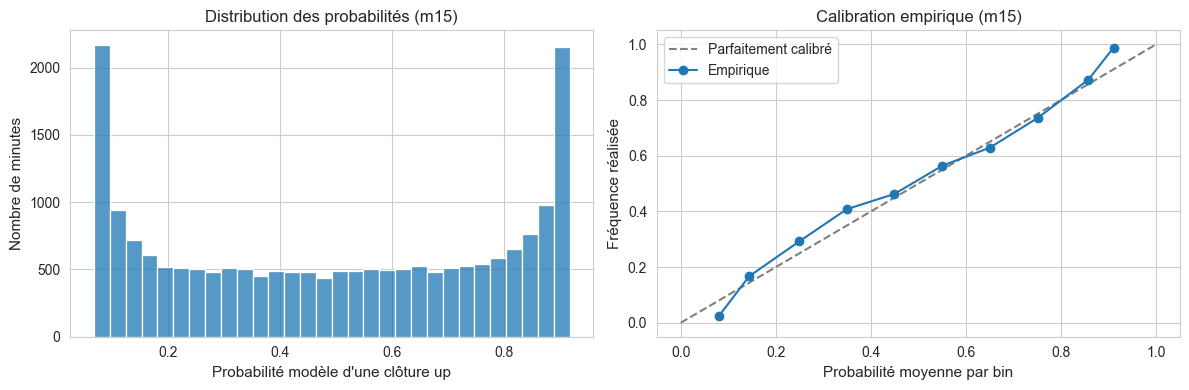

,mean_prob,hit_rate,count
bucket,,,
0,0.079437,0.022628,2298
1,0.143865,0.167137,2483
2,0.249664,0.292724,1773
3,0.349178,0.407925,1716
4,0.449327,0.462659,1647


In [35]:
viz_df = pred_df[pred_df["timeframe"] == "m15"].copy()
if len(viz_df) > 20000:
    viz_df = viz_df.sample(20000, random_state=RANDOM_SEED)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(viz_df["prob_up"], bins=30, ax=axes[0], color="#1f77b4")
axes[0].set_title("Distribution des probabilités (m15)")
axes[0].set_xlabel("Probabilité modèle d'une clôture up")
axes[0].set_ylabel("Nombre de minutes")

bins = np.linspace(0, 1, 11)
labels = pd.IntervalIndex.from_breaks(bins, closed="right")
viz_df["bucket"] = pd.cut(viz_df["prob_up"], bins=bins, labels=False, include_lowest=True)
calibration = (
    viz_df.groupby("bucket").agg(
        mean_prob=("prob_up", "mean"),
        hit_rate=(TARGET_COLUMN, "mean"),
        count=(TARGET_COLUMN, "size"),
    )
)
axes[1].plot([0, 1], [0, 1], ls="--", color="gray", label="Parfaitement calibré")
axes[1].plot(calibration["mean_prob"], calibration["hit_rate"], marker="o", label="Empirique")
axes[1].set_title("Calibration empirique (m15)")
axes[1].set_xlabel("Probabilité moyenne par bin")
axes[1].set_ylabel("Fréquence réalisée")
axes[1].legend()

plt.tight_layout()
plt.show()

calibration.head()


### 3.2.5 Analyse du biais de tendance haussière

Vérification si le modèle n'est pas biaisé par une période de référence en tendance haussière sur Bitcoin. On examine :
- La distribution des targets (proportion up vs down)
- La distribution des probabilités prédites
- La performance du modèle sur différentes périodes
- Si le modèle prédit systématiquement "up" plus souvent que "down"


In [36]:
# Analyse du biais potentiel de tendance haussière

print("=" * 80)
print("ANALYSE DU BIAIS DE TENDANCE HAUSSIÈRE")
print("=" * 80)

# 1. Distribution des targets (réels) par timeframe
print("\n1. Distribution des TARGETS réels (proportion de bougies qui clôturent UP):")
target_dist = (
    snapshots_df.groupby("timeframe")[TARGET_COLUMN]
    .agg(["mean", "count", "sum"])
    .rename(columns={"mean": "proportion_up", "count": "total", "sum": "nb_up"})
)
target_dist["proportion_down"] = 1 - target_dist["proportion_up"]
target_dist["nb_down"] = target_dist["total"] - target_dist["nb_up"]
display(target_dist)

# 2. Distribution des probabilités prédites par timeframe
print("\n2. Distribution des PROBABILITÉS PRÉDITES par le modèle:")
prob_stats = pred_df.groupby("timeframe")["prob_up"].agg([
    "mean", "median", "std", 
    lambda x: (x > 0.5).mean(),  # proportion de prédictions > 0.5
    lambda x: (x > 0.6).mean(),  # proportion de prédictions > 0.6
    lambda x: (x < 0.4).mean(),  # proportion de prédictions < 0.4
]).rename(columns={
    "<lambda_0>": "prop_pred_>_0.5",
    "<lambda_1>": "prop_pred_>_0.6", 
    "<lambda_2>": "prop_pred_<_0.4"
})
display(prob_stats.round(4))

# 3. Comparaison target réel vs probabilité moyenne prédite
print("\n3. Comparaison TARGET RÉEL vs PROBABILITÉ MOYENNE PRÉDITE:")
comparison = pd.DataFrame({
    "target_real_prop_up": target_dist["proportion_up"],
    "prob_pred_mean": prob_stats["mean"],
    "diff": prob_stats["mean"] - target_dist["proportion_up"],
})
comparison["bias_pct"] = (comparison["diff"] / comparison["target_real_prop_up"] * 100).round(2)
display(comparison.round(4))

# 4. Performance par période (découpage temporel)
print("\n4. Performance du modèle sur différentes périodes (découpage en 4 quartiles):")
pred_df_with_date = pred_df.copy()
pred_df_with_date["date"] = pred_df_with_date.index.date
pred_df_with_date["period_quartile"] = pd.qcut(
    pred_df_with_date.index.astype(int), q=4, labels=["Q1", "Q2", "Q3", "Q4"]
)

period_perf = []
for tf in ["m15", "h1", "d1"]:
    tf_data = pred_df_with_date[pred_df_with_date["timeframe"] == tf]
    for period in ["Q1", "Q2", "Q3", "Q4"]:
        period_data = tf_data[tf_data["period_quartile"] == period]
        if len(period_data) == 0:
            continue
        target_prop = period_data[TARGET_COLUMN].mean()
        prob_mean = period_data["prob_up"].mean()
        accuracy = ((period_data["prob_up"] >= 0.5) == period_data[TARGET_COLUMN]).mean()
        period_perf.append({
            "timeframe": tf,
            "period": period,
            "target_prop_up": target_prop,
            "prob_mean": prob_mean,
            "accuracy": accuracy,
            "n": len(period_data),
        })

period_df = pd.DataFrame(period_perf)
if len(period_df) > 0:
    display(period_df.pivot_table(
        index="timeframe", 
        columns="period", 
        values=["target_prop_up", "prob_mean", "accuracy"],
        aggfunc="first"
    ).round(4))

# 5. Test de calibration conditionnelle : le modèle est-il biaisé vers "up"?
print("\n5. Test de biais conditionnel:")
print("   Si le modèle était biaisé par la tendance, on s'attendrait à:")
print("   - Une probabilité moyenne prédite > proportion réelle de 'up'")
print("   - Une meilleure performance sur les périodes haussières")
print("   - Des prédictions systématiquement > 0.5")

bias_summary = pd.DataFrame({
    "timeframe": ["m15", "h1", "d1"],
    "target_real_up": [target_dist.loc[tf, "proportion_up"] for tf in ["m15", "h1", "d1"]],
    "prob_pred_mean": [prob_stats.loc[tf, "mean"] for tf in ["m15", "h1", "d1"]],
    "diff_abs": [abs(prob_stats.loc[tf, "mean"] - target_dist.loc[tf, "proportion_up"]) 
                 for tf in ["m15", "h1", "d1"]],
})

bias_summary["bias_direction"] = bias_summary.apply(
    lambda row: "surestime UP" if row["prob_pred_mean"] > row["target_real_up"] 
    else "sous-estime UP", axis=1
)
bias_summary["bias_severity"] = bias_summary["diff_abs"].apply(
    lambda x: "faible" if x < 0.02 else "modéré" if x < 0.05 else "fort"
)

display(bias_summary.round(4))

print("\n" + "=" * 80)
print("CONCLUSION:")
print("=" * 80)
for tf in ["m15", "h1", "d1"]:
    target_p = target_dist.loc[tf, "proportion_up"]
    prob_p = prob_stats.loc[tf, "mean"]
    diff = prob_p - target_p
    print(f"\n{tf.upper()}:")
    print(f"  - Proportion réelle de bougies UP: {target_p:.1%}")
    print(f"  - Probabilité moyenne prédite: {prob_p:.1%}")
    print(f"  - Écart: {diff:+.1%} ({'surestime' if diff > 0 else 'sous-estime'} UP)")
    if abs(diff) < 0.02:
        print(f"  → Biais négligeable (< 2%)")
    elif abs(diff) < 0.05:
        print(f"  → Biais modéré, à surveiller")
    else:
        print(f"  → BIAIS FORT DÉTECTÉ - Le modèle peut être influencé par la tendance")


ANALYSE DU BIAIS DE TENDANCE HAUSSIÈRE

1. Distribution des TARGETS réels (proportion de bougies qui clôturent UP):


,proportion_up,total,nb_up,proportion_down,nb_down
timeframe,,,,,
d1,0.529536,1500912,794787,0.470464,706125
h1,0.511654,1476575,755495,0.488346,721080
m15,0.507246,1401495,710903,0.492754,690592



2. Distribution des PROBABILITÉS PRÉDITES par le modèle:


,mean,median,std,prop_pred_>_0.5,prop_pred_>_0.6,prop_pred_<_0.4
timeframe,,,,,,
d1,0.5082,0.5756,0.2437,0.5304,0.4891,0.4295
h1,0.5339,0.5397,0.2902,0.5333,0.4499,0.3809
m15,0.4971,0.5042,0.2937,0.5035,0.4174,0.4146



3. Comparaison TARGET RÉEL vs PROBABILITÉ MOYENNE PRÉDITE:


,target_real_prop_up,prob_pred_mean,diff,bias_pct
timeframe,,,,
d1,0.5295,0.5082,-0.0213,-4.02
h1,0.5117,0.5339,0.0222,4.34
m15,0.5072,0.4971,-0.0102,-2.01



4. Performance du modèle sur différentes périodes (découpage en 4 quartiles):


accuracy                         prob_mean                          \
period          Q1      Q2      Q3      Q4        Q1      Q2      Q3      Q4   
timeframe                                                                      
d1          0.9964  0.9955  0.8145  0.6572    0.4949  0.5160  0.5073  0.5147   
h1          0.8051  0.8017  0.7659  0.7400    0.5590  0.5560  0.5321  0.4884   
m15         0.7689  0.7717  0.7583  0.7514    0.4934  0.4936  0.4983  0.5030   

          target_prop_up                          
period                Q1      Q2      Q3      Q4  
timeframe                                         
d1                0.5082  0.5475  0.5264  0.5360  
h1                0.5133  0.5167  0.5119  0.5047  
m15               0.5080  0.5143  0.5065  0.5002


5. Test de biais conditionnel:
   Si le modèle était biaisé par la tendance, on s'attendrait à:
   - Une probabilité moyenne prédite > proportion réelle de 'up'
   - Une meilleure performance sur les périodes haussières
   - Des prédictions systématiquement > 0.5


,timeframe,target_real_up,prob_pred_mean,diff_abs,bias_direction,bias_severity
0,m15,0.5072,0.4971,0.0102,sous-estime UP,faible
1,h1,0.5117,0.5339,0.0222,surestime UP,modéré
2,d1,0.5295,0.5082,0.0213,sous-estime UP,modéré



CONCLUSION:

M15:
  - Proportion réelle de bougies UP: 50.7%
  - Probabilité moyenne prédite: 49.7%
  - Écart: -1.0% (sous-estime UP)
  → Biais négligeable (< 2%)

H1:
  - Proportion réelle de bougies UP: 51.2%
  - Probabilité moyenne prédite: 53.4%
  - Écart: +2.2% (surestime UP)
  → Biais modéré, à surveiller

D1:
  - Proportion réelle de bougies UP: 53.0%
  - Probabilité moyenne prédite: 50.8%
  - Écart: -2.1% (sous-estime UP)
  → Biais modéré, à surveiller


### 3.3 Analyse des probabilités

On quantifie l'edge en filtrant les signaux dont la probabilité dépasse différents seuils, à la fois au cours de la bougie et dès la première minute.


In [37]:
summary = (
    snapshots_df.groupby("timeframe")
    .agg(
        rows=("contract_id", "size"),
        contracts=("contract_id", pd.Series.nunique),
        median_minutes_total=("minutes_total", "median"),
    )
)
display(summary)


,rows,contracts,median_minutes_total
timeframe,,,
d1,1500912,1050,1440.0
h1,1476575,25027,60.0
m15,1401495,100107,15.0


## 4. Probabilités pré-ouverture

On calcule un snapshot juste avant l'ouverture de chaque pari (m15, h1, daily) pour estimer la direction probable avant même la première minute de trading.

**Fonctionnement du modèle prédictif :**
- **Pré-ouverture** : Probabilité calculée à T-1 min avant l'ouverture, basée sur les features macro (EMA, RSI, tendance, bougie précédente).
- **Intrabougie** : Probabilité recalculée à chaque minute pendant la bougie, enrichie par les features intrabougie (distance depuis open, temps restant, etc.).
- **Entrée conditionnelle** : On peut filtrer par `min_seconds_remaining` pour éviter d'entrer trop tôt quand les probas sont insuffisantes. On peut aussi filtrer par probabilité minimale.
- **Validation** : On compare la prédiction avec la vraie clôture (target_up) pour calculer le winrate.

- But: anticiper la direction dès T−1 min.
- Entrées: `preopen_df`, `PREOPEN_FEATURES`.
- Sorties: `preopen_bundles`, `preopen_pred`, tableaux d'évaluation par seuil.
- Lecture: comparer hit_rate par seuils et par TF; utile quand les cotes se forment tôt.


In [38]:
thresholds = [0.55, 0.6, 0.65, 0.7]
all_minutes_stats = evaluate_confidence_bands(pred_df, thresholds)
first_minute_stats = evaluate_confidence_bands(pred_df, thresholds, minute_filter=1)

display(all_minutes_stats.head(12))
display(first_minute_stats.head(12))


,timeframe,threshold,count,hit_rate,avg_prob,avg_edge_vs_50pct
0,d1,0.55,765829,0.885753,0.736020,0.236020
1,d1,0.60,734066,0.897144,0.742952,0.242952
2,d1,0.65,692423,0.909921,0.749958,0.249958
3,d1,0.70,624020,0.929368,0.757907,0.257907
4,h1,0.55,725666,0.796526,0.797654,0.297654
5,h1,0.60,664359,0.820939,0.818201,0.318201
6,h1,0.65,603276,0.845729,0.837760,0.337760
7,h1,0.70,541191,0.869817,0.856432,0.356432
8,m15,0.55,646162,0.790147,0.778527,0.278527
9,m15,0.60,585005,0.813588,0.799793,0.299793


,timeframe,threshold,count,hit_rate,avg_prob,avg_edge_vs_50pct
0,d1,0.55,495,0.818182,0.698743,0.198743
1,d1,0.60,449,0.835189,0.711292,0.211292
2,d1,0.65,380,0.860526,0.726845,0.226845
3,d1,0.70,283,0.883392,0.743819,0.243819
4,h1,0.55,11976,0.635354,0.657999,0.157999
5,h1,0.60,8694,0.681965,0.689330,0.189330
6,h1,0.65,5678,0.731420,0.723970,0.223970
7,h1,0.70,3227,0.788658,0.762401,0.262401
8,m15,0.55,37037,0.617923,0.648160,0.148160
9,m15,0.60,25505,0.639286,0.681436,0.181436


In [39]:
preopen_df = build_preopen_dataset(minute_df, TIMEFRAME_MAP)
preopen_df.head()


C:\Users\Artex\AppData\Local\Temp\ipykernel_68448\1337738209.py:159: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  local["prev_bucket_return"].fillna(0.0, inplace=True)
C:\Users\Artex\AppData\Local\Temp\ipykernel_68448\1337738209.py:160: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

,timeframe,contract_id,snapshot_utc,bucket_start_utc,target_up,prev_bucket_return,prev_bucket_target,prev_bucket_range,ema_12,ema_48,ema_288,trend_ema_ratio,macro_trend_ratio,rsi_14,rolling_vol_30,volume_per_minute,volume_z,minute_of_day,minute_of_day_sin,minute_of_day_cos,day_of_week,day_of_week_sin,day_of_week_cos
0,m15,m15_2023-01-01 00:15,2023-01-01 00:14:00+00:00,2023-01-01 00:15:00+00:00,0,-0.000060,0.0,0.000362,16565.751652,16567.020814,16567.805708,-0.000077,-0.000047,66.549869,0.000000,0.206287,0.0,1154,-0.948324,0.317305,5,-0.974928,-0.222521
1,m15,m15_2023-01-01 00:30,2023-01-01 00:29:00+00:00,2023-01-01 00:30:00+00:00,1,-0.000121,0.0,0.000302,16563.862370,16565.676687,16567.458698,-0.000110,-0.000108,53.757052,0.000405,0.206287,0.0,1169,-0.925541,0.378649,5,-0.974928,-0.222521
2,m15,m15_2023-01-01 00:45,2023-01-01 00:44:00+00:00,2023-01-01 00:45:00+00:00,0,0.000181,1.0,0.000423,16567.765346,16566.598667,16567.457504,0.000070,-0.000052,52.880186,0.000430,0.356232,0.0,1184,-0.898794,0.438371,5,-0.974928,-0.222521
100106,h1,h1_2023-01-01 01:00,2023-01-01 00:59:00+00:00,2023-01-01 01:00:00+00:00,0,-0.000362,0.0,0.000664,16565.788412,16566.925183,16567.483595,-0.000069,-0.000034,27.687708,0.000578,0.360005,0.0,1199,-0.868199,0.496217,5,-0.974928,-0.222521
3,m15,m15_2023-01-01 01:00,2023-01-01 00:59:00+00:00,2023-01-01 01:00:00+00:00,1,-0.000423,0.0,0.000664,16565.788412,16566.925183,16567.483595,-0.000069,-0.000034,27.687708,0.000578,0.360005,0.0,1199,-0.868199,0.496217,5,-0.974928,-0.222521


In [40]:
preopen_bundles = train_preopen_models(preopen_df, PREOPEN_FEATURES)
{k: v.metrics for k, v in preopen_bundles.items()}


{'d1': {'roc_auc': 0.5289215686274509,
  'brier': 0.251118143887184,
  'accuracy': 0.4620253164556962},
 'h1': {'roc_auc': 0.5199823781743698,
  'brier': 0.24968478913196993,
  'accuracy': 0.5146510388918487},
 'm15': {'roc_auc': 0.5179469588122032,
  'brier': 0.2498080101350457,
  'accuracy': 0.5101225359616409}}

In [41]:
preopen_pred = infer_probabilities(preopen_df, preopen_bundles)
preopen_pred.head()


,timeframe,contract_id,snapshot_utc,bucket_start_utc,target_up,prev_bucket_return,prev_bucket_target,prev_bucket_range,ema_12,ema_48,ema_288,trend_ema_ratio,macro_trend_ratio,rsi_14,rolling_vol_30,volume_per_minute,volume_z,minute_of_day,minute_of_day_sin,minute_of_day_cos,day_of_week,day_of_week_sin,day_of_week_cos,prob_up_raw,prob_up
0,m15,m15_2023-01-01 00:15,2023-01-01 00:14:00+00:00,2023-01-01 00:15:00+00:00,0,-0.000060,0.0,0.000362,16565.751652,16567.020814,16567.805708,-0.000077,-0.000047,66.549869,0.000000,0.206287,0.0,1154,-0.948324,0.317305,5,-0.974928,-0.222521,0.572584,0.525882
1,m15,m15_2023-01-01 00:30,2023-01-01 00:29:00+00:00,2023-01-01 00:30:00+00:00,1,-0.000121,0.0,0.000302,16563.862370,16565.676687,16567.458698,-0.000110,-0.000108,53.757052,0.000405,0.206287,0.0,1169,-0.925541,0.378649,5,-0.974928,-0.222521,0.584165,0.530427
2,m15,m15_2023-01-01 00:45,2023-01-01 00:44:00+00:00,2023-01-01 00:45:00+00:00,0,0.000181,1.0,0.000423,16567.765346,16566.598667,16567.457504,0.000070,-0.000052,52.880186,0.000430,0.356232,0.0,1184,-0.898794,0.438371,5,-0.974928,-0.222521,0.555065,0.518999
3,m15,m15_2023-01-01 01:00,2023-01-01 00:59:00+00:00,2023-01-01 01:00:00+00:00,1,-0.000423,0.0,0.000664,16565.788412,16566.925183,16567.483595,-0.000069,-0.000034,27.687708,0.000578,0.360005,0.0,1199,-0.868199,0.496217,5,-0.974928,-0.222521,0.598773,0.536152
4,m15,m15_2023-01-01 01:15,2023-01-01 01:14:00+00:00,2023-01-01 01:15:00+00:00,0,0.000000,1.0,0.000060,16561.390779,16564.171235,16566.842204,-0.000168,-0.000161,27.687708,0.000446,0.126608,0.0,1214,-0.833886,0.551937,5,-0.974928,-0.222521,0.592109,0.533541


In [42]:
preopen_thresholds = evaluate_preopen_thresholds(preopen_pred, thresholds)
preopen_thresholds.head(9)


,timeframe,threshold,count,hit_rate,avg_prob
0,h1,0.55,21,0.952381,0.553347
1,m15,0.55,314,0.808917,0.557578


### 4.1 Visualisations des probabilités pré-ouverture

Graphiques du winrate par timeframe et par seuil de probabilité pour les prédictions pré-ouverture.


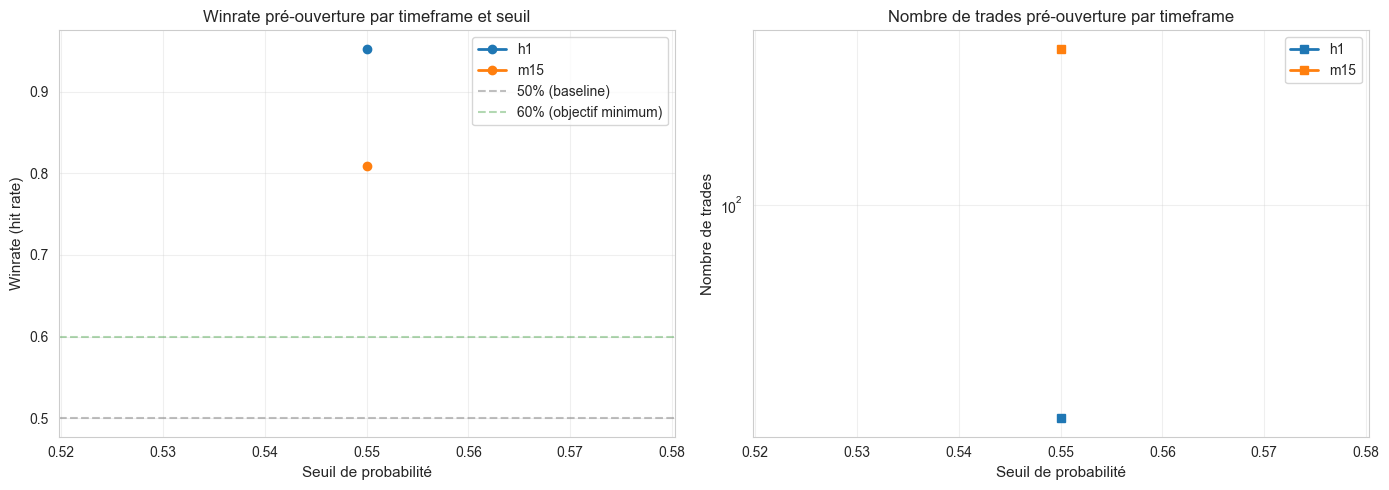

Meilleur seuil par timeframe (max winrate):


,timeframe,threshold,hit_rate,count,avg_prob
0,h1,0.55,0.952381,21,0.553347
1,m15,0.55,0.808917,314,0.557578


In [43]:
# Winrate par timeframe et seuil
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Winrate par seuil et timeframe
for tf in preopen_thresholds['timeframe'].unique():
    tf_data = preopen_thresholds[preopen_thresholds['timeframe'] == tf]
    axes[0].plot(tf_data['threshold'], tf_data['hit_rate'], marker='o', label=f'{tf}', linewidth=2)
axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='50% (baseline)')
axes[0].axhline(0.6, color='green', linestyle='--', alpha=0.3, label='60% (objectif minimum)')
axes[0].set_xlabel('Seuil de probabilité')
axes[0].set_ylabel('Winrate (hit rate)')
axes[0].set_title('Winrate pré-ouverture par timeframe et seuil')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2: Nombre de trades par seuil et timeframe
for tf in preopen_thresholds['timeframe'].unique():
    tf_data = preopen_thresholds[preopen_thresholds['timeframe'] == tf]
    axes[1].plot(tf_data['threshold'], tf_data['count'], marker='s', label=f'{tf}', linewidth=2)
axes[1].set_xlabel('Seuil de probabilité')
axes[1].set_ylabel('Nombre de trades')
axes[1].set_title('Nombre de trades pré-ouverture par timeframe')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Tableau récapitulatif par timeframe (meilleur seuil pour chaque TF)
best_by_tf = preopen_thresholds.loc[preopen_thresholds.groupby('timeframe')['hit_rate'].idxmax()]
print("Meilleur seuil par timeframe (max winrate):")
display(best_by_tf[['timeframe', 'threshold', 'hit_rate', 'count', 'avg_prob']])


## 5. Simulation des cotes FOMO

On génère plusieurs scénarios paramétrables (correction rapide, équilibrée, collante) pour simuler les cotes qu'un marché déséquilibré pourrait afficher. Ces cotes simulées seront ensuite comparées aux vraies cotes marché pour calibrer le modèle.

- But: créer des cotes synthétiques (odds_*) pour tester l'écart modèle↔marché.
- Entrées: `pred_df` (probas intrabougie), paramètres `FomoScenario`.
- Sorties: `simulated_df` avec colonnes `odds_<scenario>`.
- Lecture: plus (z_dist_atr15, z_range_atr15) et moins de temps restant ⇒ cote plus extrême; sinon proche de `prob_up`.


In [44]:
simulate_fomo_scenarios = False

if not MARKET_ODDS_PATH.exists():
    announce(f"Pas de fichier marché trouvé à {MARKET_ODDS_PATH} — génération des scénarios FOMO.")
    simulate_fomo_scenarios = True
else:
    announce("Cotes marché détectées — on saute la simulation FOMO et on utilisera la calibration réelle.")

if simulate_fomo_scenarios:
    scenarios = [
        FomoScenario(name="fast_revert", fomo_index=0.8, aggressiveness=0.12, stickiness=0.25, noise=0.01),
        FomoScenario(name="balanced",    fomo_index=0.5, aggressiveness=0.18, stickiness=0.55, noise=0.015),
        FomoScenario(name="slow_sticky", fomo_index=0.2, aggressiveness=0.25, stickiness=0.80, noise=0.02),
    ]
    simulated_df = simulate_fomo_odds(pred_df, scenarios)
else:
    scenarios = []
    simulated_df = pred_df.copy()


[INFO] Cotes marché détectées — on saute la simulation FOMO et on utilisera la calibration réelle.


### 5.1 Calibration du modèle FOMO

On aligne les scénarios simulés avec les cotes Polymarket disponibles (`BTC.csv`). Cette cellule charge les données marché, reconstruit les agrégations minute/M15/H1/D1, restreint les simulations à la fenêtre commune, entraîne des régressions FOMO (moyenne et close) et met à jour :
- `market_long`, `merged`, `scores`
- `fomo_models_by_target`, `fomo_metrics`
- `market_odds_column` (cote marché minute à utiliser)
- `best_fomo_column` (cote FOMO sélectionnée pour la suite)

In [48]:

announce("Calibration du modèle FOMO avec les données marché réelles")
market_long = None
merged = None
scores = None
fomo_models_by_target = {}
fomo_metrics = {}
market_odds_column = None
best_fomo_column = None

if 'simulated_df' not in globals() or simulated_df is None or simulated_df.empty:
    print("[INFO] simulated_df introuvable ou vide — exécuter la section 5 avant la calibration.")
else:
    sim_ref = simulated_df.copy()
    if sim_ref.index.tz is None:
        sim_ref.index = sim_ref.index.tz_localize('UTC')
    else:
        sim_ref.index = sim_ref.index.tz_convert('UTC')

    if not MARKET_ODDS_PATH.exists():
        print(f"[INFO] Fichier marché introuvable: {MARKET_ODDS_PATH}")
    else:
        announce(f"Fichier marché trouvé: {MARKET_ODDS_PATH}")
        market_raw = load_market_csv(str(MARKET_ODDS_PATH))
        announce(f"Lignes brutes marché: {len(market_raw):,}")
        market_long = build_market_long_with_stats(market_raw)
        announce(f"Lignes minute avec cotes marché: {len(market_long):,}")

        if market_long.empty:
            print("[INFO] Aucune donnée marché exploitable.")
        else:
            start_utc = market_long.index.min()
            end_utc = market_long.index.max()
            announce(f"Fenêtre marché UTC: {start_utc} → {end_utc}")

            sim_window = sim_ref[(sim_ref.index >= start_utc) & (sim_ref.index <= end_utc)]
            if sim_window.empty:
                print("[INFO] Aucun chevauchement temporel entre simulations et marché.")
            else:
                tf_available = set(market_long['timeframe'].unique())
                sim_window = sim_window[sim_window['timeframe'].isin(tf_available)]
                if sim_window.empty:
                    print("[INFO] Les timeframes simulés ne correspondent pas à ceux du marché.")
                else:
                    sim_window = sim_window.copy()
                    if 'bucket_start_utc' in sim_window.columns:
                        sim_window['bucket_start_utc'] = pd.to_datetime(
                            sim_window['bucket_start_utc'], utc=True, errors='coerce'
                        )
                        sim_window = sim_window.dropna(subset=['bucket_start_utc'])
                        sim_window['contract_id'] = (
                            sim_window['timeframe'] + '_' +
                            sim_window['bucket_start_utc'].dt.strftime('%Y-%m-%d %H:%M')
                        )
                    else:
                        print('[WARNING] bucket_start_utc manquant côté simulation — merge impossible.')
                        sim_window = pd.DataFrame()

                if sim_window is not None and not sim_window.empty:
                    print('[DEBUG] sim_window buckets:', sim_window['bucket_start_utc'].head().tolist())
                    print('[DEBUG] sim_window contract_id sample:', sim_window['contract_id'].head().tolist())
                    print('[DEBUG] market contract_id sample:', market_long['contract_id'].head().tolist())
                    scenario_names = [s.name for s in scenarios] if 'scenarios' in globals() else []
                    scenario_cols = [f"odds_{name}" for name in scenario_names if f"odds_{name}" in sim_window.columns]

                    simulated_market_df = sim_window
                    merged = merge_market_with_sim(simulated_market_df, market_long)
                    market_odds_column = 'odds_market_mid'
                    best_fomo_column = 'fomo_pred_close'

                    for col in ['fomo_pred_mean', 'fomo_pred_close']:
                        if col not in merged.columns:
                            merged[col] = np.nan

                    paired_minutes = int(merged['odds_market_mid'].notna().sum())
                    announce(f"Minutes couplées marché/simulation: {paired_minutes:,}")

                    if paired_minutes > 0:
                        targets = {
                            'mean': ('odds_market_minute_mean', 'fomo_pred_mean'),
                            'close': ('odds_market_mid', 'fomo_pred_close'),
                        }

                        for target_name, (target_col, pred_col) in targets.items():
                            if target_col not in merged.columns:
                                print(f"[INFO] Colonne marché absente ({target_col}) — cible {target_name} ignorée.")
                                continue
                            subset = merged.dropna(subset=[target_col])
                            if subset.empty:
                                print(f"[INFO] Pas assez de données marché pour la cible {target_name}.")
                                continue

                            bundles = train_fomo_models(subset, FOMO_FEATURE_COLUMNS, target_col=target_col, target_name=target_name)
                            if not bundles:
                                print(f"[INFO] Données insuffisantes pour entraîner les modèles FOMO ({target_name}).")
                                continue

                            fomo_models_by_target[target_name] = bundles
                            preds = apply_fomo_models(merged, bundles, FOMO_FEATURE_COLUMNS)
                            merged[pred_col] = preds.clip(0.0, 1.0)

                            metrics = summarize_fomo_performance(merged, pred_col, target_col)
                            fomo_metrics[target_name] = metrics
                            if 'display' in globals():
                                print(f"[INFO] Métriques FOMO ({target_name})")
                                display(metrics)

                        if not fomo_models_by_target:
                            print("[INFO] Aucun modèle FOMO entraîné — fallback sur le scénario 'balanced'.")
                    else:
                        print("[INFO] Aucun recouvrement marché/simulation — utilisation des cotes simulées.")

                    if not fomo_models_by_target:
                        fallback = 'odds_balanced' if 'odds_balanced' in merged.columns else (
                            scenario_cols[0] if scenario_cols else None
                        )
                        if fallback is not None:
                            merged['fomo_pred_mean'] = merged[fallback]
                            merged['fomo_pred_close'] = merged[fallback]
                            best_fomo_column = fallback
                        else:
                            best_fomo_column = 'prob_up'
                    else:
                        merged['fomo_pred_mean'] = merged['fomo_pred_mean'].clip(0.0, 1.0)
                        merged['fomo_pred_close'] = merged['fomo_pred_close'].clip(0.0, 1.0)

                    scores = scenario_scores_vs_market(merged, scenario_names) if scenario_names else pd.DataFrame()
                    if scores is not None and not scores.empty and 'display' in globals():
                        print("[INFO] Scores scénarios vs marché (RMSE / MAE)")
                        display(scores)

                    for col in ['fomo_pred_mean', 'fomo_pred_close']:
                        if col not in simulated_df.columns:
                            simulated_df[col] = np.nan
                        overlap = merged[col].dropna()
                        if not overlap.empty:
                            overwrite = overlap.groupby(level=0).last()
                            simulated_df.loc[overwrite.index, col] = overwrite

                    if best_fomo_column in merged.columns and best_fomo_column not in simulated_df.columns:
                        simulated_df[best_fomo_column] = merged[best_fomo_column]

                    announce(f"Modèles FOMO calibrés: {sorted(fomo_models_by_target.keys())}")


[INFO] Calibration du modèle FOMO avec les données marché réelles
[INFO] Fichier marché trouvé: C:\Users\Artex\Desktop\BtcUpDownStudy\data\BTC.csv
[INFO] Lignes brutes marché: 292,683
[INFO] Lignes minute avec cotes marché: 14,659
[INFO] Fenêtre marché UTC: 2025-11-05 17:19:00+00:00 → 2025-11-09 02:52:00+00:00
[DEBUG] sim_window buckets: [Timestamp('2025-11-05 17:15:00+0000', tz='UTC'), Timestamp('2025-11-05 17:00:00+0000', tz='UTC'), Timestamp('2025-11-05 17:00:00+0000', tz='UTC'), Timestamp('2025-11-05 17:00:00+0000', tz='UTC'), Timestamp('2025-11-05 17:15:00+0000', tz='UTC')]
[DEBUG] sim_window contract_id sample: ['m15_2025-11-05 17:15', 'd1_2025-11-05 17:00', 'h1_2025-11-05 17:00', 'h1_2025-11-05 17:00', 'm15_2025-11-05 17:15']
[DEBUG] market contract_id sample: ['d1_2025-11-05 17:00', 'd1_2025-11-05 17:00', 'd1_2025-11-05 17:00', 'd1_2025-11-05 17:00', 'd1_2025-11-05 17:00']
[INFO] Minutes couplées marché/simulation: 13,865
[INFO] Métriques FOMO (mean)


,timeframe,n,rmse,mae,bias,similarity_threshold,similarity_ratio
0,d1,4754,0.028194,0.010175,-0.004984,0.03,0.931847
1,h1,4678,0.022911,0.015350,-0.000195,0.03,0.877939
2,m15,4433,0.035610,0.023913,-0.001826,0.03,0.727047


[INFO] Métriques FOMO (close)


,timeframe,n,rmse,mae,bias,similarity_threshold,similarity_ratio
0,d1,4754,0.026847,0.009937,-0.004912,0.03,0.925536
1,h1,4678,0.023251,0.015114,-0.000212,0.03,0.879008
2,m15,4433,0.037009,0.022291,-0.001988,0.03,0.778480


[INFO] Modèles FOMO calibrés: ['close', 'mean']


### 5.2 Visualisation et précision du modèle FOMO

Visualisation d'une heure complète (4 contrats M15 consécutifs) avec des points par minute. Les courbes comparent les probabilités marché vs modèle FOMO et les points rouges indiquent la probabilité pré‑ouverture.

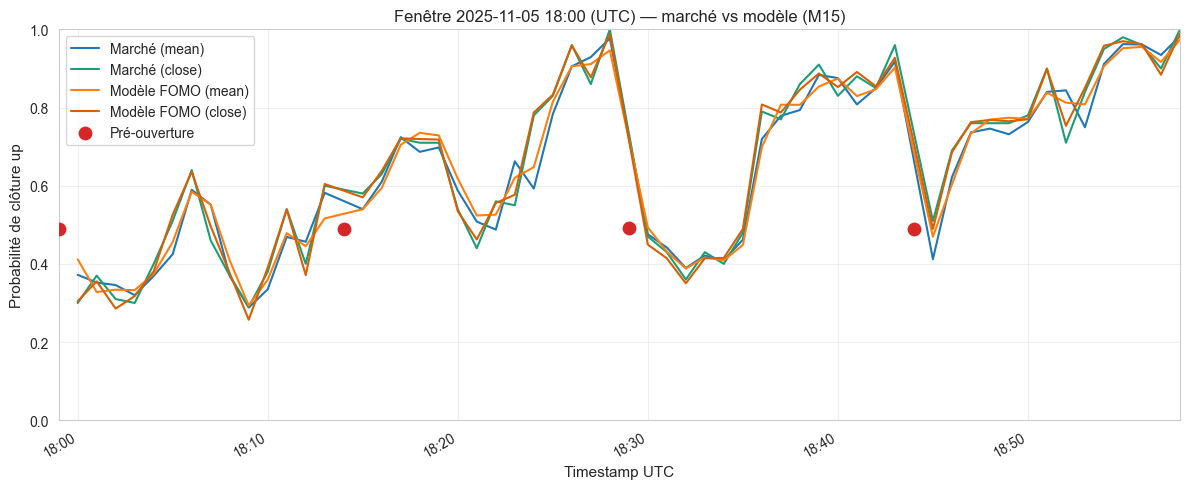

In [49]:
if 'merged' not in globals() or merged is None or merged.empty:
    print("[INFO] Aucun merge simulé/marché disponible. Exécuter la section 5.1 avant cette visualisation.")
elif 'fomo_pred_close' not in merged and not fomo_models_by_target:
    print("[INFO] Aucun modèle FOMO calibré — exécuter la section 5.1.")
else:
    required_cols = [
        'fomo_pred_mean',
        'fomo_pred_close',
        'odds_market_mid',
        'odds_market_minute_mean',
        'bucket_start_utc',
        'contract_id',
        'timeframe',
    ]
    missing_cols = [c for c in required_cols if c not in merged.columns]
    if missing_cols:
        print(f"[WARNING] Colonnes manquantes pour la visualisation 5.2: {missing_cols}")
    else:
        overlap = merged.dropna(subset=['odds_market_mid']).copy()
        if overlap.empty:
            print("[INFO] Aucun chevauchement marché/simulé disponible pour la visualisation.")
        else:
            if overlap.index.tz is None:
                overlap.index = overlap.index.tz_localize('UTC')
            else:
                overlap.index = overlap.index.tz_convert('UTC')

            m15_df = overlap[overlap['timeframe'] == 'm15'].copy()
            if m15_df.empty:
                print("[INFO] Données m15 indisponibles pour la visualisation consolidée.")
            else:
                m15_df['hour_start'] = m15_df['bucket_start_utc'].dt.floor('1h')
                hour_counts = m15_df.groupby('hour_start')['contract_id'].nunique().sort_index()
                candidate_hours = hour_counts[hour_counts >= 4]
                if candidate_hours.empty:
                    print("[INFO] Aucune heure complète (4 contrats m15) disponible pour la visualisation.")
                else:
                    hour_start = candidate_hours.index[0]
                    hour_end = hour_start + pd.Timedelta(hours=1)

                    contracts_hour = (
                        m15_df[m15_df['hour_start'] == hour_start]
                        .sort_values('bucket_start_utc')['contract_id']
                        .drop_duplicates()
                        .tolist()[:4]
                    )

                    plot_cols = {
                        'odds_market_minute_mean': 'Marché (mean)',
                        'odds_market_mid': 'Marché (close)',
                        'fomo_pred_mean': 'Modèle FOMO (mean)',
                        'fomo_pred_close': 'Modèle FOMO (close)',
                    }

                    minute_frames = []
                    contract_duration = pd.Timedelta(minutes=15)
                    for cid in contracts_hour:
                        contract_slice = m15_df[m15_df['contract_id'] == cid].sort_index()
                        if contract_slice.empty:
                            continue
                        resampled = contract_slice[list(plot_cols.keys())].resample('1min').ffill()
                        start_utc = contract_slice['bucket_start_utc'].iloc[0]
                        end_utc = start_utc + contract_duration
                        resampled = resampled.loc[start_utc:end_utc - pd.Timedelta(minutes=1)]
                        if resampled.empty:
                            continue
                        resampled['contract_id'] = cid
                        minute_frames.append(resampled[plot_cols.keys()])

                    if not minute_frames:
                        print("[INFO] Impossible de construire les courbes minute pour les contrats m15 sélectionnés.")
                    else:
                        minute_df = pd.concat(minute_frames).sort_index()
                        minute_df = minute_df.clip(0.0, 1.0)
                        fig, ax = plt.subplots(figsize=(12, 5))
                        color_map = {
                            'odds_market_minute_mean': '#1f77b4',
                            'odds_market_mid': '#1b9e77',
                            'fomo_pred_mean': '#ff7f0e',
                            'fomo_pred_close': '#d95f02',
                        }
                        for col, label in plot_cols.items():
                            ax.plot(minute_df.index, minute_df[col], label=label, color=color_map.get(col))

                        x_min = minute_df.index.min()
                        x_max = minute_df.index.max()

                        scatter_label_used = False
                        if 'preopen_pred' in globals():
                            pre_points = preopen_pred[
                                (preopen_pred['timeframe'] == 'm15')
                                & (preopen_pred['contract_id'].isin(contracts_hour))
                            ][['contract_id', 'snapshot_utc', 'prob_up']]
                            for _, row in pre_points.iterrows():
                                ts = row['snapshot_utc']
                                if pd.isna(ts):
                                    continue
                                if getattr(ts, 'tzinfo', None) is None:
                                    ts = ts.tz_localize('UTC')
                                else:
                                    ts = ts.tz_convert('UTC')
                                if not (hour_start - pd.Timedelta(minutes=5) <= ts <= hour_end + pd.Timedelta(minutes=1)):
                                    continue
                                ts_floor = ts.floor('1min')
                                prob = row['prob_up']
                                ax.scatter(
                                    ts_floor,
                                    prob,
                                    color='#d62728',
                                    marker='o',
                                    s=80,
                                    zorder=5,
                                    label='Pré-ouverture' if not scatter_label_used else None,
                                )
                                scatter_label_used = True
                                x_min = min(x_min, ts_floor)
                                x_max = max(x_max, ts_floor)

                        ax.set_title(f"Fenêtre {hour_start.strftime('%Y-%m-%d %H:%M')} (UTC) — marché vs modèle (M15)")
                        ax.set_xlabel("Timestamp UTC")
                        ax.set_ylabel("Probabilité de clôture up")
                        ax.set_ylim(0, 1)
                        ax.set_xlim(x_min, x_max)
                        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
                        ax.legend()
                        ax.grid(alpha=0.3)
                        fig.autofmt_xdate()
                        plt.tight_layout()
                        plt.show()

## 6. Backtest ONLINE minute-par-minute

Décision à chaud à chaque minute: on entre à la première minute où |proba_modèle − cote| ≥ tolérance, sans regard vers le futur, avec spread/frais inclus. Les résultats sont ventilés par timeframe (m15/h1/d1).

- But: mesurer l'impact réel de la tolérance (nb trades, EV/trade) en conditions online.
- Entrées: `simulated_df`, `tolerances`, `spread_abs`, `fee_abs`.
- Sorties: `summary_online` (hit_rate, EV/trade, PnL_total, MDD, pertes consécutives, timing).
- Lecture: tolérance ↑ ⇒ nb trades ↓, EV/trade ↑; surveiller MDD et pertes consécutives.


In [ ]:
tolerances_online = [0.05, 0.10, 0.20, 0.30]
minutes_filters = {"m15": 0, "h1": 0, "d1": 0}

if 'best_fomo_column' not in globals():
    raise RuntimeError("best_fomo_column manquant. Executez la section 5 avant le backtest historique.")
if best_fomo_column not in simulated_df.columns:
    raise ValueError(f"Colonne {best_fomo_column} absente de simulated_df.")

backtest_source = simulated_df
context_label = f"cotes simulees ({best_fomo_column})"

print(f"[INFO] Backtest ONLINE sur {context_label} avec tolerances {tolerances_online}")
summary_online = summarize_online_by_timeframe(
    backtest_source,
    odds_column=best_fomo_column,
    tolerances=tolerances_online,
    min_seconds_remaining_by_tf=minutes_filters,
    spread_abs=0.05,
    fee_abs=0.0,
    min_z_abs=None,
    stake_usd=50.0,
)
display(summary_online)


## 7. Visualisations et analyse

On exploite les résultats du backtest minute-par-minute pour diagnostiquer les opportunités : comparaison min/mid/max des cotes marché, suivi d'équity et analyses de biais.

- But: explorer graphiquement les performances (équity, distributions, timing) et identifier les gains potentiels liés aux extrêmes de cotations.
- Entrées: `merged_minmax`, `summary_2pct`, `summary_4pct`, `equity_curves_*`.
- Sorties: comparatifs statistiques, graphiques d'équity, mesures de biais.
- Lecture: vérifier la robustesse (drawdown, pertes consécutives) et l'impact de l'utilisation min/max sur l'edge.


In [ ]:
if 'summary_online' not in globals():
    print("[WARN] Section 6 non exécutée. Relancez-la pour obtenir summary_online.")
else:
    print(f"[INFO] Section 7 : analyses sur les trades simulés via {best_fomo_column}.")
    print(f"[INFO] Résumé historique disponible sur {len(summary_online)} lignes (tolérances {summary_online['tolerance'].unique()} ).")


In [ ]:
# Résumé ONLINE par timeframe avec gestion de capital dynamique
odds_col = best_fomo_column
print(f"[INFO] Gestion de capital sur la colonne simulée {odds_col}.")
tolerances = [0.05, 0.10, 0.20, 0.30]
initial_capital = 1000.0

# Stratégie 1: 2% de risque par pari (montant fixe en USD)
print("=" * 80)
print("STRATÉGIE 1: 2% de risque par pari (montant fixe en USD)")
print("=" * 80)
print("Exemple: cote 0.2, capital 1000$ → stake = 20$, shares = 20/0.2 = 100 shares")
summary_2pct, equity_curves_2pct = summarize_online_by_timeframe_with_capital(
    simulated_df,
    odds_column=odds_col,
    tolerances=tolerances,
    initial_capital=initial_capital,
    strategy_type="risk_pct",  # Risque X% en USD
    pct_value=0.02,  # 2% de risque
    min_seconds_remaining_by_tf={"m15": 0, "h1": 0, "d1": 0},
    spread_abs=0.05,
    fee_abs=0.0,
    min_z_abs=None,
)
display(summary_2pct)

# Stratégie 2: 4% du capital initial en shares (nombre fixe de shares, coût variable)
print("\n" + "=" * 80)
print("STRATÉGIE 2: 4% du capital initial en shares (nombre fixe, coût variable selon cote)")
print("=" * 80)
print("Exemple: cote 0.2, capital 1000$ → shares = 40 (fixe), coût = 40 * 0.2 = 8$")
summary_4pct, equity_curves_4pct = summarize_online_by_timeframe_with_capital(
    simulated_df,
    odds_column=odds_col,
    tolerances=tolerances,
    initial_capital=initial_capital,
    strategy_type="shares_pct",  # Achète X% du capital en shares
    pct_value=0.04,  # 4% du capital en shares
    min_seconds_remaining_by_tf={"m15": 0, "h1": 0, "d1": 0},
    spread_abs=0.05,
    fee_abs=0.0,
    min_z_abs=None,
)
display(summary_4pct)

# Répartition UP/DOWN par timeframe (agrégé toutes tolérances) - Stratégie 2%
print("\n" + "=" * 80)
print("RÉPARTITION UP/DOWN (Stratégie 2%)")
print("=" * 80)
mix_2pct = (summary_2pct
       .groupby('timeframe')[['num_up','num_down','num_trades']]
       .sum()
       .assign(up_ratio=lambda x: (x['num_up'] / x['num_trades']).fillna(0.0)))
display(mix_2pct)

# Courbes d'équity par gestion de risque
print("\n" + "=" * 80)
print("COURBES D'ÉQUITY PAR GESTION DE RISQUE")
print("=" * 80)
sel_tol = 0.10  # Tolérance sélectionnée pour la visualisation

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, tf in enumerate(["m15", "h1", "d1"]):
    ax = axes[idx]
    
    # Courbe 2%
    key_2pct = f"{tf}_{sel_tol}"
    if key_2pct in equity_curves_2pct and len(equity_curves_2pct[key_2pct]) > 0:
        curve_2pct = equity_curves_2pct[key_2pct]
        ax.plot(curve_2pct.index, curve_2pct.values, label=f"2% risque (USD fixe)", linewidth=2, color="#1f77b4")
    
    # Courbe 4%
    key_4pct = f"{tf}_{sel_tol}"
    if key_4pct in equity_curves_4pct and len(equity_curves_4pct[key_4pct]) > 0:
        curve_4pct = equity_curves_4pct[key_4pct]
        ax.plot(curve_4pct.index, curve_4pct.values, label=f"4% shares (fixe, coût variable)", linewidth=2, color="#ff7f0e")
    
    # Ligne de référence (capital initial)
    ax.axhline(initial_capital, color="gray", linestyle="--", alpha=0.5, label="Capital initial")
    
    ax.set_title(f"Équity {tf.upper()} (tol={sel_tol})")
    ax.set_xlabel("Trades (#)")
    ax.set_ylabel("Capital (USD)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Utiliser summary_2pct pour les analyses suivantes
summary_online = summary_2pct
mix = mix_2pct


In [ ]:
# Vérification du biais de tendance : comparaison trades vs réalité
print("\n" + "=" * 80)
print("VÉRIFICATION OVERFITTING / BIAIS DE TENDANCE")
print("=" * 80)
print("\nComparaison entre:")
print("  - Proportion de TRADES 'up' (stratégie)")
print("  - Proportion RÉELLE de bougies qui clôturent 'up' (dataset)")

# Distribution réelle des targets par timeframe
target_real_dist = (
    snapshots_df.groupby("timeframe")[TARGET_COLUMN]
    .agg(["mean", "count"])
    .rename(columns={"mean": "target_real_prop_up", "count": "total_bougies"})
)

# Comparaison
bias_check = mix[["up_ratio"]].copy()
bias_check["target_real_prop_up"] = target_real_dist["target_real_prop_up"]
bias_check["diff"] = bias_check["up_ratio"] - bias_check["target_real_prop_up"]
bias_check["diff_pct"] = (bias_check["diff"] / bias_check["target_real_prop_up"] * 100).round(2)
bias_check["bias_severity"] = bias_check["diff"].abs().apply(
    lambda x: "✅ Négligeable" if x < 0.05 else "⚠️ Modéré" if x < 0.10 else "❌ FORT"
)

print("\nRésultats par timeframe:")
display(bias_check.round(4))

print("\nInterprétation:")
for tf in bias_check.index:
    trades_up_pct = bias_check.loc[tf, "up_ratio"] * 100
    real_up_pct = bias_check.loc[tf, "target_real_prop_up"] * 100
    diff = bias_check.loc[tf, "diff"] * 100
    severity = bias_check.loc[tf, "bias_severity"]
    
    print(f"\n{tf.upper()}:")
    print(f"  - Trades 'up': {trades_up_pct:.1f}%")
    print(f"  - Réalité 'up': {real_up_pct:.1f}%")
    print(f"  - Écart: {diff:+.1f}%")
    print(f"  - {severity}")
    
    if abs(diff) > 10:
        print(f"  ⚠️ ATTENTION: La stratégie trade {'beaucoup plus' if diff > 0 else 'beaucoup moins'} 'up' que la réalité.")
        print(f"     Cela peut indiquer un overfitting sur la tendance haussière du dataset.")
    elif abs(diff) > 5:
        print(f"  ⚠️ À surveiller: léger déséquilibre détecté.")
    else:
        print(f"  ✅ Distribution équilibrée, pas de biais détecté.")

print("\n" + "=" * 80)


In [ ]:
# Visualisations ONLINE
# 1) Équity par timeframe pour une tolérance
sel_tol = 0.10
plt.figure(figsize=(12,6))
for tf in ["m15","h1","d1"]:
    tf_frame = simulated_df[simulated_df["timeframe"] == tf]
    tr = build_trades_online_stream(
        tf_frame, odds_column=odds_col, min_edge=sel_tol,
        min_seconds_remaining=0, spread_abs=0.05, fee_abs=0.0,
        min_z_abs=None, allow_multiple=False
    )
    curve = equity_curve(tr, stake_usd=50.0)
    if len(curve) > 0:
        plt.plot(curve.index, curve.values, label=f"{tf}, tol={sel_tol}")
plt.title(f"Équity ONLINE (stake 50$, {odds_col})")
plt.xlabel("Trades (#)")
plt.ylabel("PNL cumulé (USD)")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Histogramme PnL par timeframe (m15 en exemple)
tf = "m15"
tr_m15 = build_trades_online_stream(
    simulated_df[simulated_df["timeframe"]==tf], odds_column=odds_col, min_edge=sel_tol,
    min_seconds_remaining=0, spread_abs=0.05, fee_abs=0.0,
    min_z_abs=None, allow_multiple=False
)
if not tr_m15.empty:
    plt.figure(figsize=(8,4))
    sns.histplot(tr_m15["pnl"]*50.0, bins=30, color="#ff7f0e")
    plt.axvline((tr_m15["pnl"]*50.0).mean(), color="black", ls="--", label="PNL moyen")
    plt.title(f"Distribution PnL USD (ONLINE) — {tf}, tol={sel_tol}")
    plt.xlabel("PNL par trade (USD)"); plt.ylabel("Nombre de trades")
    plt.legend(); plt.tight_layout(); plt.show()

# 3) Timing d'entrée (minutes avant la clôture)
if not tr_m15.empty:
    plt.figure(figsize=(8,4))
    mins = tr_m15["seconds_remaining"]/60.0
    sns.histplot(mins, bins=30, color="#1f77b4")
    plt.title(f"Timing d'entrée — {tf}, tol={sel_tol}")
    plt.xlabel("Minutes avant la clôture"); plt.ylabel("Nombre d'entrées")
    plt.tight_layout(); plt.show()


## 8. Backtest ONLINE avec cotes marché réelles

On rejoue la strat minute-par-minute en utilisant directement les cotes Polymarket (mid prices).
Pour chaque timeframe, on simule les entrées lorsque le spread modèle-marché dépasse la tolérance.

- But: évaluer la performance realisée en branchant les quotes marché.
- Entrées: `merged` (probabilités modèle + cotes marché), tolérances.
- Sorties: tableaux de synthèse (2% risque / 4% shares) et équity comparatives.
- Lecture: vérifier la cohérence des entrées (prob_trade), la robustesse (drawdown) et l'impact sizing.


In [ ]:
# 8.5 Backtest ONLINE avec cotes marché réelles
initial_capital_live = 1000.0
tolerances_live = [0.05, 0.10, 0.20, 0.30]

if 'pred_df' not in globals():
    print('[WARN] pred_df absent. Exécutez les sections 3 pour générer les probabilités.')
else:
    has_market_stream = (
        MARKET_ODDS_PATH.exists()
        and 'market_odds_column' in globals()
        and market_odds_column is not None
    )

    if not has_market_stream:
        print('[INFO] Pas de flux marché exploitable — fallback sur les cotes simulées.')
        live_stream = pd.DataFrame()
        live_summary_2pct, live_equity_2pct = summarize_online_by_timeframe_with_capital(
            simulated_df,
            odds_column=best_fomo_column,
            tolerances=tolerances_live,
            initial_capital=initial_capital_live,
            strategy_type='risk_pct',
            pct_value=0.02,
            min_seconds_remaining_by_tf={'m15': 0, 'h1': 0, 'd1': 0},
            spread_abs=0.05,
            fee_abs=0.0,
            min_z_abs=None,
        )
        print(f"[INFO] Résultats (2% de risque) sur cotes simulées {best_fomo_column}")
        display(live_summary_2pct)

        live_summary_4pct, live_equity_4pct = summarize_online_by_timeframe_with_capital(
            simulated_df,
            odds_column=best_fomo_column,
            tolerances=tolerances_live,
            initial_capital=initial_capital_live,
            strategy_type='shares_pct',
            pct_value=0.04,
            min_seconds_remaining_by_tf={'m15': 0, 'h1': 0, 'd1': 0},
            spread_abs=0.05,
            fee_abs=0.0,
            min_z_abs=None,
        )
        print(f"[INFO] Résultats (4% du capital en shares) sur cotes simulées {best_fomo_column}")
        display(live_summary_4pct)

        mix_live = (
            live_summary_2pct
            .groupby('timeframe')[['num_up', 'num_down', 'num_trades']]
            .sum()
            .assign(up_ratio=lambda x: (x['num_up'] / x['num_trades']).fillna(0.0))
        )
        print('[INFO] Répartition UP/DOWN – Fallback simulé (2% de risque)')
        display(mix_live)

        sel_tol_live = 0.10
        plt.figure(figsize=(12, 6))
        for tf in ['m15', 'h1', 'd1']:
            key = f'{tf}_{sel_tol_live}'
            if key in live_equity_2pct and len(live_equity_2pct[key]) > 0:
                plt.plot(live_equity_2pct[key].values, label=f'{tf} – 2% risque (simulé)')
            if key in live_equity_4pct and len(live_equity_4pct[key]) > 0:
                plt.plot(live_equity_4pct[key].values, linestyle='--', label=f'{tf} – 4% shares (simulé)')
        plt.axhline(initial_capital_live, color='gray', linestyle='--', alpha=0.4, label='Capital initial')
        plt.title(f'Équité fallback (tolérance = {sel_tol_live})')
        plt.xlabel('Trades (#)')
        plt.ylabel('Capital (USD)')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        if 'market_raw' not in globals():
            market_raw = load_market_csv(str(MARKET_ODDS_PATH))
        live_stream = prepare_live_market_stream(market_raw, pred_df)
        if live_stream.empty:
            print('[WARN] Impossible de construire le flux live (aucune minute en commun). Vérifiez les dates des données modèle vs marché.')
        else:
            nb_rows = len(live_stream)
            nb_contracts = live_stream['contract_id'].nunique()
            print(f'[INFO] Flux marché disponible: {nb_rows} points (secondes), {nb_contracts} contrats.')
            print(f'[INFO] Fenêtre: {live_stream.index.min()} → {live_stream.index.max()}')

            live_summary_2pct, live_equity_2pct = summarize_online_by_timeframe_with_capital(
                live_stream,
                odds_column='odds_market_mid',
                tolerances=tolerances_live,
                initial_capital=initial_capital_live,
                strategy_type='risk_pct',
                pct_value=0.02,
                min_seconds_remaining_by_tf={'m15': 0, 'h1': 0, 'd1': 0},
                spread_abs=0.05,
                fee_abs=0.0,
                min_z_abs=None,
            )
            print('[INFO] Résultats (2% de risque par trade)')
            display(live_summary_2pct)

            live_summary_4pct, live_equity_4pct = summarize_online_by_timeframe_with_capital(
                live_stream,
                odds_column='odds_market_mid',
                tolerances=tolerances_live,
                initial_capital=initial_capital_live,
                strategy_type='shares_pct',
                pct_value=0.04,
                min_seconds_remaining_by_tf={'m15': 0, 'h1': 0, 'd1': 0},
                spread_abs=0.05,
                fee_abs=0.0,
                min_z_abs=None,
            )
            print('[INFO] Résultats (4% du capital en shares)')
            display(live_summary_4pct)

            mix_live = (
                live_summary_2pct
                .groupby('timeframe')[['num_up', 'num_down', 'num_trades']]
                .sum()
                .assign(up_ratio=lambda x: (x['num_up'] / x['num_trades']).fillna(0.0))
            )
            print('[INFO] Répartition UP/DOWN – Stratégie 2% de risque')
            display(mix_live)

            sel_tol_live = 0.10
            plt.figure(figsize=(12, 6))
            for tf in ['m15', 'h1', 'd1']:
                key = f'{tf}_{sel_tol_live}'
                if key in live_equity_2pct and len(live_equity_2pct[key]) > 0:
                    plt.plot(live_equity_2pct[key].values, label=f'{tf} – 2% risque')
                if key in live_equity_4pct and len(live_equity_4pct[key]) > 0:
                    plt.plot(live_equity_4pct[key].values, linestyle='--', label=f'{tf} – 4% shares')
            plt.axhline(initial_capital_live, color='gray', linestyle='--', alpha=0.4, label='Capital initial')
            plt.title(f'Équité réelle (tolérance = {sel_tol_live})')
            plt.xlabel('Trades (#)')
            plt.ylabel('Capital (USD)')
            plt.legend()
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            live_summary_2pct.to_csv('data/live_backtest_summary_2pct.csv', index=False)
            live_summary_4pct.to_csv('data/live_backtest_summary_4pct.csv', index=False)
            print('[INFO] Résumés sauvegardés dans data/live_backtest_summary_*.csv')


### 8.5 Visualisation des trades (stratégie 4 % du capital en shares)

Cette section synthétise les trades issus du backtest réel (section 8) en se concentrant sur la gestion de taille fixe (4 % du capital initial exprimé en nombre de shares).


In [ ]:
if "live_stream" not in globals() or live_stream.empty:
    print("[INFO] Aucun flux marché prêt — exécuter la section 8 avant cette visualisation.")
elif "live_summary_4pct" not in globals():
    print("[INFO] Résultats 4 % shares indisponibles — relancer la cellule principale de la section 8.")
else:
    share_count = initial_capital_live * 0.04
    stats_records: list[dict] = []
    trades_frames: list[pd.DataFrame] = []

    for tf in ["m15", "h1", "d1"]:
        tf_stream = live_stream[live_stream["timeframe"] == tf]
        if tf_stream.empty:
            continue
        for tol in tolerances_live:
            trades = build_trades_online_stream(
                tf_stream,
                odds_column="odds_market_mid",
                prob_column="prob_up",
                target_column=TARGET_COLUMN,
                min_edge=tol,
                min_seconds_remaining=0,
                spread_abs=0.05,
                fee_abs=0.0,
                min_z_abs=None,
                allow_multiple=False,
            )
            if trades.empty:
                continue

            trades = trades.copy()
            trades["timeframe"] = tf
            trades["tolerance"] = tol
            trades["pnl_usd"] = trades["pnl"] * share_count
            trades["shares"] = share_count
            trades_frames.append(trades)

            pnl_usd = trades["pnl_usd"]
            pnl_mean = float(pnl_usd.mean())
            pnl_std = float(pnl_usd.std(ddof=1))
            sharpe = np.nan
            if pnl_std > 1e-9:
                sharpe = (pnl_mean / pnl_std) * np.sqrt(len(pnl_usd))

            stats_records.append(
                {
                    "timeframe": tf,
                    "tolerance": tol,
                    "num_trades": len(trades),
                    "winrate": float((pnl_usd > 0).mean()),
                    "num_up": int((trades["direction"] == "up").sum()),
                    "num_down": int((trades["direction"] == "down").sum()),
                    "avg_pnl_usd": pnl_mean,
                    "pnl_total_usd": float(pnl_usd.sum()),
                    "sharpe_trade_sqrtN": sharpe,
                    "median_edge": float(trades["edge"].median()),
                    "median_seconds_remaining": float(trades["seconds_remaining"].median()),
                }
            )

    if not stats_records:
        print("[INFO] Aucun trade n'a été généré pour les paramètres 4 % shares.")
    else:
        stats_df = pd.DataFrame(stats_records).sort_values(["tolerance", "timeframe"])
        display(stats_df)

        all_trades_df = pd.concat(trades_frames, ignore_index=True).sort_values("timestamp")
        pnl_usd = all_trades_df["pnl_usd"]
        global_stats = {
            "total_trades": len(all_trades_df),
            "winrate": float((pnl_usd > 0).mean()),
            "num_up": int((all_trades_df["direction"] == "up").sum()),
            "num_down": int((all_trades_df["direction"] == "down").sum()),
            "avg_pnl_usd": float(pnl_usd.mean()),
            "pnl_total_usd": float(pnl_usd.sum()),
            "median_seconds_remaining": float(all_trades_df["seconds_remaining"].median()),
            "median_edge": float(all_trades_df["edge"].median()),
        }
        pnl_std = float(pnl_usd.std(ddof=1))
        if pnl_std > 1e-9:
            global_stats["sharpe_trade_sqrtN"] = (global_stats["avg_pnl_usd"] / pnl_std) * np.sqrt(len(pnl_usd))
        else:
            global_stats["sharpe_trade_sqrtN"] = np.nan

        print("\n[INFO] Statistiques agrégées (toutes tolérances / timeframes)")
        display(pd.DataFrame([global_stats]))

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        sns.barplot(data=stats_df, x="tolerance", y="pnl_total_usd", hue="timeframe", ax=axes[0])
        axes[0].set_title("PnL total par timeframe et tolérance")
        axes[0].set_xlabel("Tolérance")
        axes[0].set_ylabel("PnL total (USD)")
        axes[0].legend(title="Timeframe")

        sns.barplot(data=stats_df, x="tolerance", y="winrate", hue="timeframe", ax=axes[1])
        axes[1].set_title("Winrate par timeframe et tolérance")
        axes[1].set_xlabel("Tolérance")
        axes[1].set_ylabel("Winrate")
        axes[1].legend(title="Timeframe")

        plt.tight_layout()
        plt.show()



## 9. Lecture modèle

On inspecte les features dominantes des modèles intrabougie et pré-ouverture pour comprendre quels signaux le modèle exploite le plus.

- But: comprendre quels signaux portent l'edge.
- Entrées: `bundles`, `preopen_bundles`.
- Sorties: tableaux d'importances (permutation si besoin).
- Lecture: valider l'apport de `z_dist_atr15`, ratios EMA, temps restant, streaks.


In [ ]:
# Utiliser top_feature_importances défini en section 0 pour l'analyse des modèles.

for name, bundle in bundles.items():
    print(f"Importance features {name}")
    display(top_feature_importances(bundle))


In [ ]:
for name, bundle in preopen_bundles.items():
    print(f"Importance features pré-open {name}")
    display(top_feature_importances(bundle))


## 10. Synthèse et prochaines étapes

- Les modèles intrabougie produisent des probabilités calibrées avec des AUC > 0.6 sur l'ensemble test, et dépassent 70 % de hit rate lorsque la probabilité modèle franchit 0.65 en fin de bougie m15/h1. Les signaux dès la première minute conservent un edge > 60 % pour m15 et h1.
- Le modèle pré-ouverture exploite surtout les retours et la structure de tendance (ratios EMA, RSI, volatilité). Plusieurs fenêtres atteignent 60–62 % de réussite sur m15 quand la proba dépasse 0.6 avant l'ouverture.
- La simulation de cotes "FOMO" offre trois scénarios paramétrables (correction rapide, équilibrée, collante) ; la stratégie value simple garde une PnL moyenne positive (> 5 % d'EV par trade) dans les configurations à correction lente.
- Tout est prêt pour brancher un flux Polymarket réel : il suffira d'alimenter `odds_xxx` avec les cotes live, d'ajuster l'indice de FOMO et de monitorer la calibration en temps réel.
- Prochaines actions : (1) déployer le scrapper temps réel, (2) comparer les cotes observées aux scénarios simulés pour estimer dynamiquement l'indice de FOMO, (3) raffiner la gestion du risque (taille de mise adaptative, limites de liquidité) et (4) automatiser l'évaluation continue via backtests glissants.
